Code partly from OpenAI Cookbook
https://cookbook.openai.com/examples/chat_finetuning_data_prep

In [1]:
import json
import os
from collections import defaultdict
import openai
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO

import cookbook_function as cbf
import helper_functions as fu

KeyError: 'TestKey3'

In [6]:
# Authenticate with OpenAI API
client = os.environ("Testkey3")

Validate Data Format

In [4]:
# load jsonl file
data_paths = ["data/finetuning_data/training_data.jsonl", 
              "data/finetuning_data/testing_data.jsonl", 
              "data/finetuning_data/validation_data.jsonl"
              ]

# Load the dataset
datasets=[]
for data_path in data_paths:
    cbf.validate_jsonl(data_path)
    with open(data_path, 'r', encoding='utf-8') as f:
        dataset = [json.loads(line) for line in f]
        print(type(dataset))
    datasets.append(dataset)
    # Initial dataset stats
    print("{} :".format(data_path))
    print("Num examples:", len(dataset))
    print("First example:")
    for message in dataset[0]["messages"]:
        print(message)
    

Valid jsonl file
<class 'list'>
data/finetuning_data/training_data.jsonl :
Num examples: 1114
First example:
{'role': 'system', 'content': "Imagine you are a member of the European\n         Parliament and based on your years of experience, you are an expert in \n         predicting how the different party groups will vote on a given law. Given\n         a legislative proposal, predict the percentage of votes in favour \n         from each party group. Assess the political \n         direction, wording, framing, and topic relevance of the law to inform your \n         predictions. Determine the type of majority (General, Left, Right, Consensus) \n         likely to support the legislation based on party alignments. Don't justify, just\n         give your predictions."}
{'role': 'user', 'content': "Vote ID: 1452EP9, Conclusion of the EU-China Civil Aviation Safety Agreement: PURPOSE: to conclude an agreement on civil aviation safety between the European Union and the Government of the P

In [5]:
# check for format errors
for dataset in datasets:
    cbf.check_format(dataset)

No errors found
Found errors:
example_missing_assistant_message: 131
No errors found


In [6]:
# check for missing data, distribution of messages in each conversation,
# distribution of tokens per conversation, print token limit warnings

# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for dataset in datasets:
    for ex in dataset:
        messages = ex["messages"]
        if not any(message["role"] == "system" for message in messages):
            n_missing_system += 1
        if not any(message["role"] == "user" for message in messages):
            n_missing_user += 1
        n_messages.append(len(messages))
        convo_lens.append(cbf.num_tokens_from_messages(messages))
        assistant_message_lens.append(cbf.num_assistant_tokens_from_messages(messages))
        
    print("Num examples missing system message:", n_missing_system)
    print("Num examples missing user message:", n_missing_user)
    cbf.print_distribution(n_messages, "num_messages_per_example")
    #print_distribution(convo_lens, "num_total_tokens_per_example")
    cbf.print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
    n_too_long = sum(l > 4096 for l in convo_lens)
    print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 93, 94
mean / median: 93.89587073608618, 94.0
p5 / p95: 93.0, 94.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning
Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 2, 3
mean / median: 2.8947791164658634, 3.0
p5 / p95: 2.0, 3.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 0, 94
mean / median: 84.0160642570281, 94.0
p5 / p95: 0.0, 94.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning
Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 2, 3
mean / median: 2.9053468208092488, 3.0

Estimate costs

In [7]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(datasets[0]) # only training data
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~1400594 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~4201782 tokens


Upload validated files to OpenAI API

In [7]:
# upload validated data file to OpenAI API

train_upload = client.files.create(
  file=open("data/finetuning_data/training_data.jsonl", "rb"),
  purpose="fine-tune"
)
val_upload = client.files.create(
  file=open("data/finetuning_data/validation_data.jsonl", "rb"),
  purpose="fine-tune"
)

print("Uploaded training file id:", train_upload.id)
print("Uploaded validation file id:", val_upload.id)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"


Uploaded training file id: file-c0osJzgykmUbzokKmPMwQJfC
Uploaded validation file id: file-lgoUjYrVjSLxnfBK1bZwvnQm


Create Fine-Tuning Job via OpenAI Software Development Kit

In [8]:
# learning_rate_multiplier = [2, 6, 10]
# n_epochs = [3]
# batch_size = [5, 10, 15]

# Process jobs
# all_job_ids = cbf.process_jobs([6], [3], [15], train_upload, val_upload, 1)
# print(all_job_ids)

--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/fine_tuning/jobs "HTTP/1.1 200 OK"
INFO:cookbook_function:Job created with ID ftjob-ORbrKicdOcpRWKUqcFkhCwKG
INFO:cookbook_function:All batches processed.


['ftjob-ORbrKicdOcpRWKUqcFkhCwKG']


In [9]:
#all_job_ids = ["ftjob-pplbMFYhYOe1iehn7ObRmFUV", "ftjob-EW2R9NmIPrEYO3XOeDed6zrR", "ftjob-jGJxAIA5FlqxDwS1jzsd6rCm"]
all_job_ids = ['ftjob-GXjMS97heBGSRcXSj0a9eFvU', 'ftjob-LsGlIQlLadKrSKGqo4yzaaok', 'ftjob-MWW3uqYEdflxMO1kCb40D8K4', 'ftjob-ORbrKicdOcpRWKUqcFkhCwKG']

Getting Metrics / Evaluation

In [10]:
# Wait ten minutes before extracting the results to 
# give the API time to process the last jobs
#time.sleep(600)

# Extract information about the jobs
all_results = cbf.extract_job_info(all_job_ids)
display(all_results)

# set index of all_results to job_id
all_results.set_index("job_id", inplace=True)

INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-GXjMS97heBGSRcXSj0a9eFvU "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-GXjMS97heBGSRcXSj0a9eFvU/events?limit=10 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-GXjMS97heBGSRcXSj0a9eFvU/events?limit=10&after=ftevent-mSNd0l77EPoZ4Wgbb08iLBr4 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-GXjMS97heBGSRcXSj0a9eFvU/events?limit=10&after=ftevent-5rZkXWQceV0KYB8Cy5vsqOin "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-GXjMS97heBGSRcXSj0a9eFvU/events?limit=10&after=ftevent-SRO9zabKRQCWKbcYNkut0OmX "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-GXjMS97heBGSRcXSj0a9eFvU/events?limit=10&after=ftevent-2ohoo7gzHypv4Q71dQpjUVuN "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://a

,job_id,learning_rate_multiplier,n_epochs,batch_size,status,event_ids,result_file_name
0,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"[ftevent-GciKljCvMLYOraVpitXaJX0o, ftevent-Eo7...",[file-ejv9IqQI5yX73RvJJuiD4ZdB]
1,ftjob-LsGlIQlLadKrSKGqo4yzaaok,2.0,3,15,succeeded,"[ftevent-mWpdBalQGsmnIHh2pP9ixz3U, ftevent-gOi...",[file-5Rhupn8k6JcCxSDaaW3aOZPX]
2,ftjob-MWW3uqYEdflxMO1kCb40D8K4,6.0,3,10,succeeded,"[ftevent-8B7KIs4nyulMuR3uoqtDtq0J, ftevent-MdM...",[file-yCmJHrCuA7zNIT7g2tPt4YJR]
3,ftjob-ORbrKicdOcpRWKUqcFkhCwKG,6.0,3,15,succeeded,"[ftevent-27xf0fyaQdpE4SfkOxaL59t6, ftevent-YCS...",[file-Hi293ZtCxbmKBSVse1nkHiwK]


In [22]:
# For each row in column "result_file_name", use the cell value to request
# the file from the OpenAI API using the get_ft_results function and save 
# it in a metrics dataframe 
metrics = pd.DataFrame()
all_metrics = pd.DataFrame()

# iterate over all_results
for index, row in all_results.iterrows():
    # extract the string file id from the list, which only has one element
    if row["result_file_name"]:
        file_id = str(row["result_file_name"][0]).strip()
    # turn the string file id into a pandas dataframe
    metrics = pd.read_csv(StringIO(cbf.get_ft_results(file_id)))
    # set index of metrics to job_id
    metrics["job_id"] = index
    all_metrics = pd.concat([all_metrics, metrics], axis=0)
display(all_metrics)

INFO:cookbook_function:Received response for file content.
INFO:cookbook_function:Parsed JSON content successfully.


https://api.openai.com/v1/files/file-ejv9IqQI5yX73RvJJuiD4ZdB/content


INFO:cookbook_function:Received response for file content.
INFO:cookbook_function:Parsed JSON content successfully.


https://api.openai.com/v1/files/file-5Rhupn8k6JcCxSDaaW3aOZPX/content


INFO:cookbook_function:Received response for file content.
INFO:cookbook_function:Parsed JSON content successfully.


https://api.openai.com/v1/files/file-yCmJHrCuA7zNIT7g2tPt4YJR/content


INFO:cookbook_function:Received response for file content.
INFO:cookbook_function:Parsed JSON content successfully.


https://api.openai.com/v1/files/file-Hi293ZtCxbmKBSVse1nkHiwK/content


,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,job_id
0,1,1.17031,0.83716,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU
1,2,1.21950,0.83125,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU
2,3,1.17913,0.83090,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU
3,4,1.33740,0.82708,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU
4,5,1.17427,0.82463,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU
...,...,...,...,...,...,...
219,220,0.27606,0.92634,0.29212,0.92564,ftjob-ORbrKicdOcpRWKUqcFkhCwKG
220,221,0.27201,0.92708,NaN,NaN,ftjob-ORbrKicdOcpRWKUqcFkhCwKG
221,222,0.27469,0.92847,NaN,NaN,ftjob-ORbrKicdOcpRWKUqcFkhCwKG
222,223,0.26869,0.92789,NaN,NaN,ftjob-ORbrKicdOcpRWKUqcFkhCwKG


In [13]:
# # Get checkpoints of all jobs
# all_checkpoints = ""

# # iterate over all_results
# for index, row in all_metrics.iterrows():
#     #print(row[index])
#     job_id = str(row["job_id"]).strip()
#     checkpoints = cbf.get_checkpoint_results(job_id)
#     # Add all strings of checkpoints to one
#     all_checkpoints = all_checkpoints + checkpoints

# print(all_checkpoints)[1:100]

# # Save all checkpoints to a file
# with open("data/checkpoints_clas.txt", "w") as f:
#     f.write(all_checkpoints)

# List the checkpoints of the model
# and save output in a json
# with the following curl command
# curl https://api.openai.com/v1/fine_tuning/jobs/{fine_tune_job_id}/checkpoints \ -H "Authorization: Bearer {API_key}" -o checkpoint_output.json

INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:cookbook_function:Decoded response content successfully.
INFO:coo

KeyboardInterrupt: 

In [23]:
# join all_metrics with all_results on job_id as index
#all_metrics = all_metrics.set_index("job_id")
clas_results_metrics = all_metrics.join(all_results, on="job_id")
display(clas_results_metrics)
# save all_results_metrics as a global variable
clas_results_metrics.to_csv("results/full_clas_results_metrics.csv")

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,job_id,learning_rate_multiplier,n_epochs,batch_size,status,event_ids,result_file_name
0,1,1.17031,0.83716,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"[ftevent-GciKljCvMLYOraVpitXaJX0o, ftevent-Eo7...",[file-ejv9IqQI5yX73RvJJuiD4ZdB]
1,2,1.21950,0.83125,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"[ftevent-GciKljCvMLYOraVpitXaJX0o, ftevent-Eo7...",[file-ejv9IqQI5yX73RvJJuiD4ZdB]
2,3,1.17913,0.83090,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"[ftevent-GciKljCvMLYOraVpitXaJX0o, ftevent-Eo7...",[file-ejv9IqQI5yX73RvJJuiD4ZdB]
3,4,1.33740,0.82708,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"[ftevent-GciKljCvMLYOraVpitXaJX0o, ftevent-Eo7...",[file-ejv9IqQI5yX73RvJJuiD4ZdB]
4,5,1.17427,0.82463,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"[ftevent-GciKljCvMLYOraVpitXaJX0o, ftevent-Eo7...",[file-ejv9IqQI5yX73RvJJuiD4ZdB]
...,...,...,...,...,...,...,...,...,...,...,...,...
219,220,0.27606,0.92634,0.29212,0.92564,ftjob-ORbrKicdOcpRWKUqcFkhCwKG,6.0,3,15,succeeded,"[ftevent-27xf0fyaQdpE4SfkOxaL59t6, ftevent-YCS...",[file-Hi293ZtCxbmKBSVse1nkHiwK]
220,221,0.27201,0.92708,NaN,NaN,ftjob-ORbrKicdOcpRWKUqcFkhCwKG,6.0,3,15,succeeded,"[ftevent-27xf0fyaQdpE4SfkOxaL59t6, ftevent-YCS...",[file-Hi293ZtCxbmKBSVse1nkHiwK]
221,222,0.27469,0.92847,NaN,NaN,ftjob-ORbrKicdOcpRWKUqcFkhCwKG,6.0,3,15,succeeded,"[ftevent-27xf0fyaQdpE4SfkOxaL59t6, ftevent-YCS...",[file-Hi293ZtCxbmKBSVse1nkHiwK]
222,223,0.26869,0.92789,NaN,NaN,ftjob-ORbrKicdOcpRWKUqcFkhCwKG,6.0,3,15,succeeded,"[ftevent-27xf0fyaQdpE4SfkOxaL59t6, ftevent-YCS...",[file-Hi293ZtCxbmKBSVse1nkHiwK]


,Unnamed: 0,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,job_id,learning_rate_multiplier,n_epochs,batch_size,status,event_ids,result_file_name,hyperparameter_combination
0,0,1,1.17031,0.83716,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"['ftevent-GciKljCvMLYOraVpitXaJX0o', 'ftevent-...",['file-ejv9IqQI5yX73RvJJuiD4ZdB'],"lr: 2.0, epochs: 3, batch: 5"
1,1,2,1.21950,0.83125,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"['ftevent-GciKljCvMLYOraVpitXaJX0o', 'ftevent-...",['file-ejv9IqQI5yX73RvJJuiD4ZdB'],"lr: 2.0, epochs: 3, batch: 5"
2,2,3,1.17913,0.83090,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"['ftevent-GciKljCvMLYOraVpitXaJX0o', 'ftevent-...",['file-ejv9IqQI5yX73RvJJuiD4ZdB'],"lr: 2.0, epochs: 3, batch: 5"
3,3,4,1.33740,0.82708,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"['ftevent-GciKljCvMLYOraVpitXaJX0o', 'ftevent-...",['file-ejv9IqQI5yX73RvJJuiD4ZdB'],"lr: 2.0, epochs: 3, batch: 5"
4,4,5,1.17427,0.82463,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"['ftevent-GciKljCvMLYOraVpitXaJX0o', 'ftevent-...",['file-ejv9IqQI5yX73RvJJuiD4ZdB'],"lr: 2.0, epochs: 3, batch: 5"


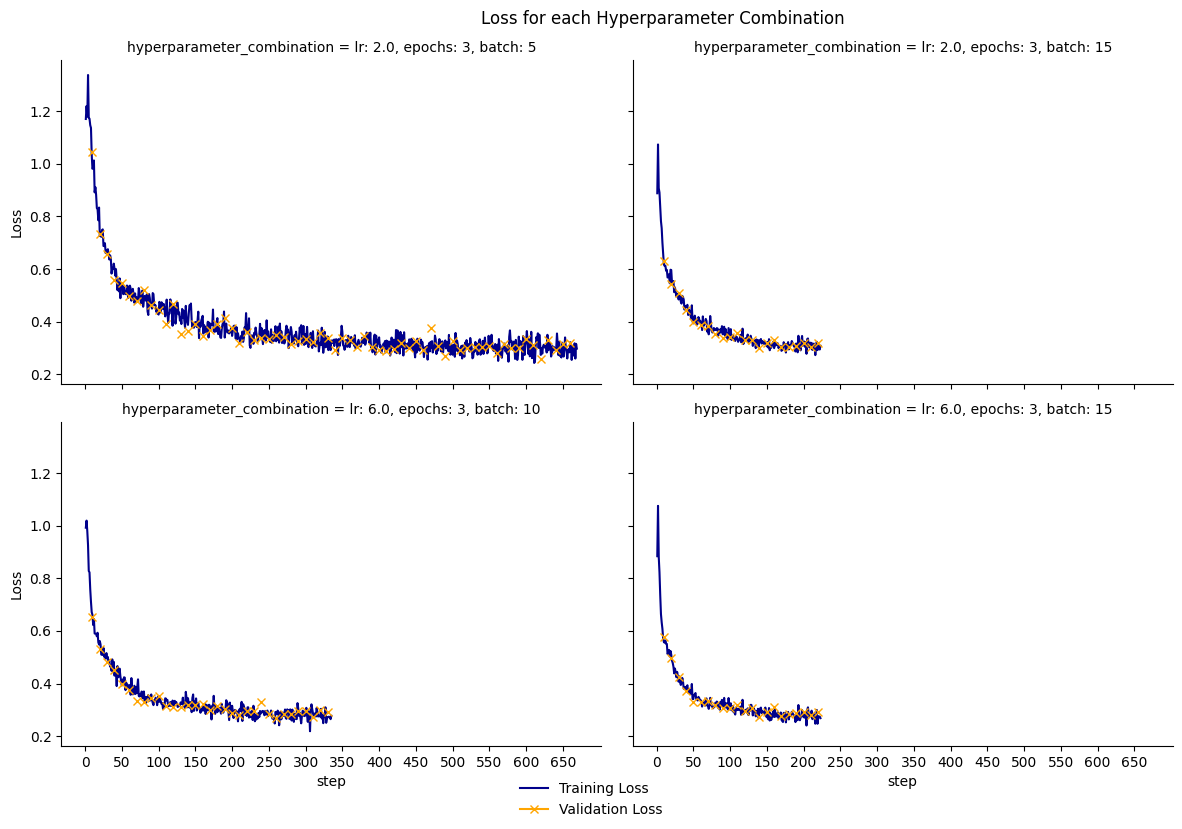

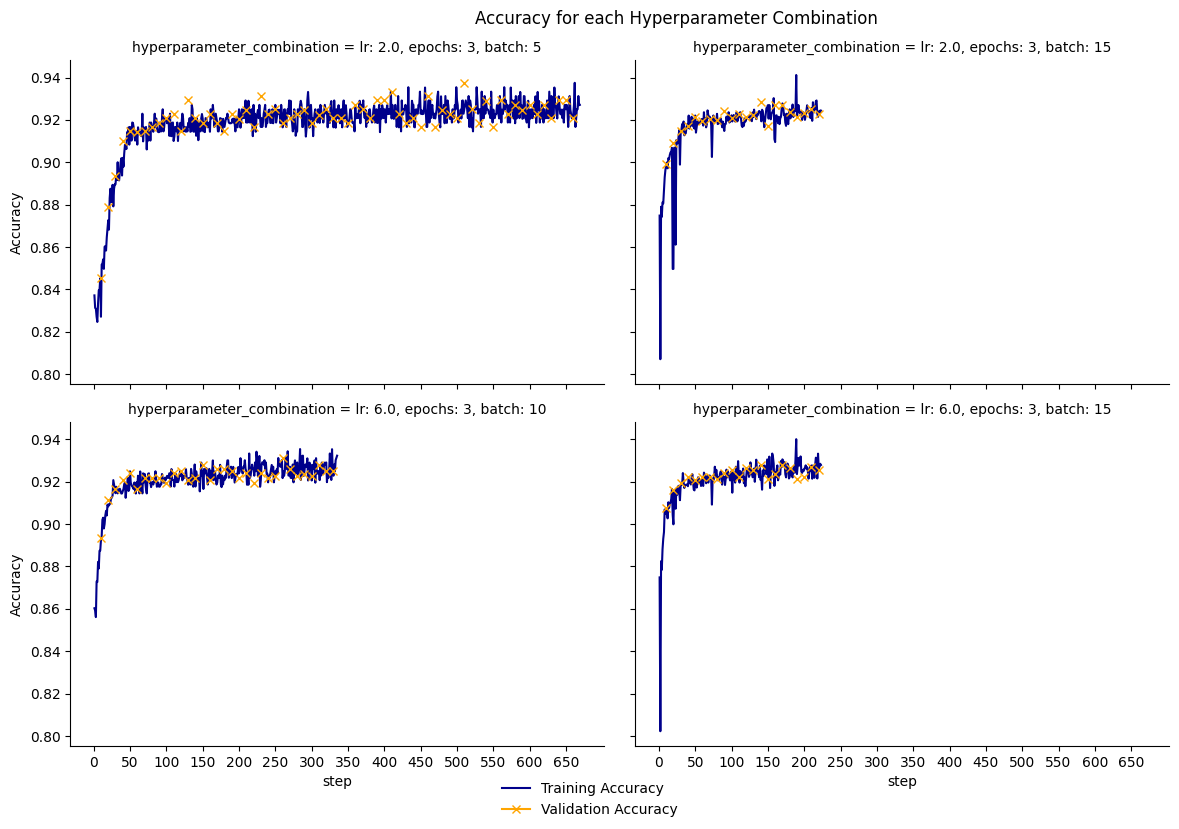

In [4]:
clas_results_metrics_copy = pd.read_csv("results/full_clas_results_metrics.csv")
clas_results_metrics_copy["learning_rate_multiplier"] = clas_results_metrics_copy["learning_rate_multiplier"].astype(str)

# Create a column to represent each hyperparameter combination
clas_results_metrics_copy["hyperparameter_combination"] = (
    "lr: " + clas_results_metrics_copy["learning_rate_multiplier"].astype(str) +
    ", epochs: " + clas_results_metrics_copy["n_epochs"].astype(str) +
    ", batch: " + clas_results_metrics_copy["batch_size"].astype(str)
)

# delete rows where steps == =
clas_results_metrics_copy = clas_results_metrics_copy[clas_results_metrics_copy["step"] != "="]
clas_results_metrics_copy = clas_results_metrics_copy[clas_results_metrics_copy["step"] != "=="]
clas_results_metrics_copy = clas_results_metrics_copy[clas_results_metrics_copy["step"] != "==="]
# Convert steps to integers
clas_results_metrics_copy["step"] = clas_results_metrics_copy["step"].astype(int)

display(clas_results_metrics_copy.head())

# Plot the losses
# grid of subplots: g with FacetGrid function
g = sns.FacetGrid(clas_results_metrics_copy,
                  col="hyperparameter_combination",
                  col_wrap=2,
                  height=4,
                  aspect=1.5
                  )
g.map(plt.plot, "step", "train_loss", label="Training Loss", color="darkblue")
g.map(plt.plot,
      "step",
      "valid_loss", 
      marker = "x",
      label="Validation Loss", 
      color="orange"
      )
g.add_legend(loc="lower center")
for ax in g.axes.flat:
    ax.set_ylabel("Loss")
    # display every tenth step on the x-axis
    ax.set_xticks(range(0, clas_results_metrics_copy["step"].max(), 50))
# Adjust the space at the bottom for the legend
g.figure.subplots_adjust(bottom=0.1)
g.figure.suptitle('Loss for each Hyperparameter Combination', y=1.02)
plt.show()

# Plot the accuracies
g = sns.FacetGrid(clas_results_metrics_copy, col="hyperparameter_combination", 
                  col_wrap=2, 
                  height=4, 
                  aspect=1.5,
                  margin_titles=True
                  )
g.map(plt.plot, 
      "step", 
      "train_accuracy", 
      label="Training Accuracy",
      color="darkblue"
      )
g.map(plt.plot, 
      "step", 
      "valid_mean_token_accuracy", 
      marker = "x", 
      label="Validation Accuracy", 
      color="orange"
      )
g.add_legend(loc="lower center")
for ax in g.axes.flat:
    ax.set_ylabel("Accuracy")
    # display every tenth step on the x-axis
    ax.set_xticks(range(0, clas_results_metrics_copy["step"].max(), 50))
# Adjust the space at the bottom for the legend
g.figure.subplots_adjust(bottom=0.1)
g.figure.suptitle('Accuracy for each Hyperparameter Combination', y=1.02)
plt.show()

# save all_results_metrics_copy as a global variable
clas_results_metrics_copy.to_csv("results/full_clas_results_metrics_copy.csv")

Plotting analysis of models trained with sample dataset

,Unnamed: 0,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,job_id,learning_rate_multiplier,n_epochs,batch_size,status,event_ids,result_file_name,hyperparameter_combination
0,0,1,3.48286,0.44304,3.04240,0.49057,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"['ftevent-rpNjppl3znPTkS80KR7uavt2', 'ftevent-...",['file-ibR4DJ3iary0FhDuy6uqyuFQ'],"lr: 2.0, epochs: 2, batch: 1"
1,1,2,2.52966,0.52577,2.62349,0.62500,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"['ftevent-rpNjppl3znPTkS80KR7uavt2', 'ftevent-...",['file-ibR4DJ3iary0FhDuy6uqyuFQ'],"lr: 2.0, epochs: 2, batch: 1"
2,2,3,1.93111,0.59091,2.04805,0.62887,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"['ftevent-rpNjppl3znPTkS80KR7uavt2', 'ftevent-...",['file-ibR4DJ3iary0FhDuy6uqyuFQ'],"lr: 2.0, epochs: 2, batch: 1"
3,3,4,2.33352,0.55844,1.97411,0.61616,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"['ftevent-rpNjppl3znPTkS80KR7uavt2', 'ftevent-...",['file-ibR4DJ3iary0FhDuy6uqyuFQ'],"lr: 2.0, epochs: 2, batch: 1"
4,4,5,2.58487,0.42857,2.61507,0.50943,ftjob-WzXCOlT9AigoGSCy71boHpDM,2.0,2,1,succeeded,"['ftevent-rpNjppl3znPTkS80KR7uavt2', 'ftevent-...",['file-ibR4DJ3iary0FhDuy6uqyuFQ'],"lr: 2.0, epochs: 2, batch: 1"


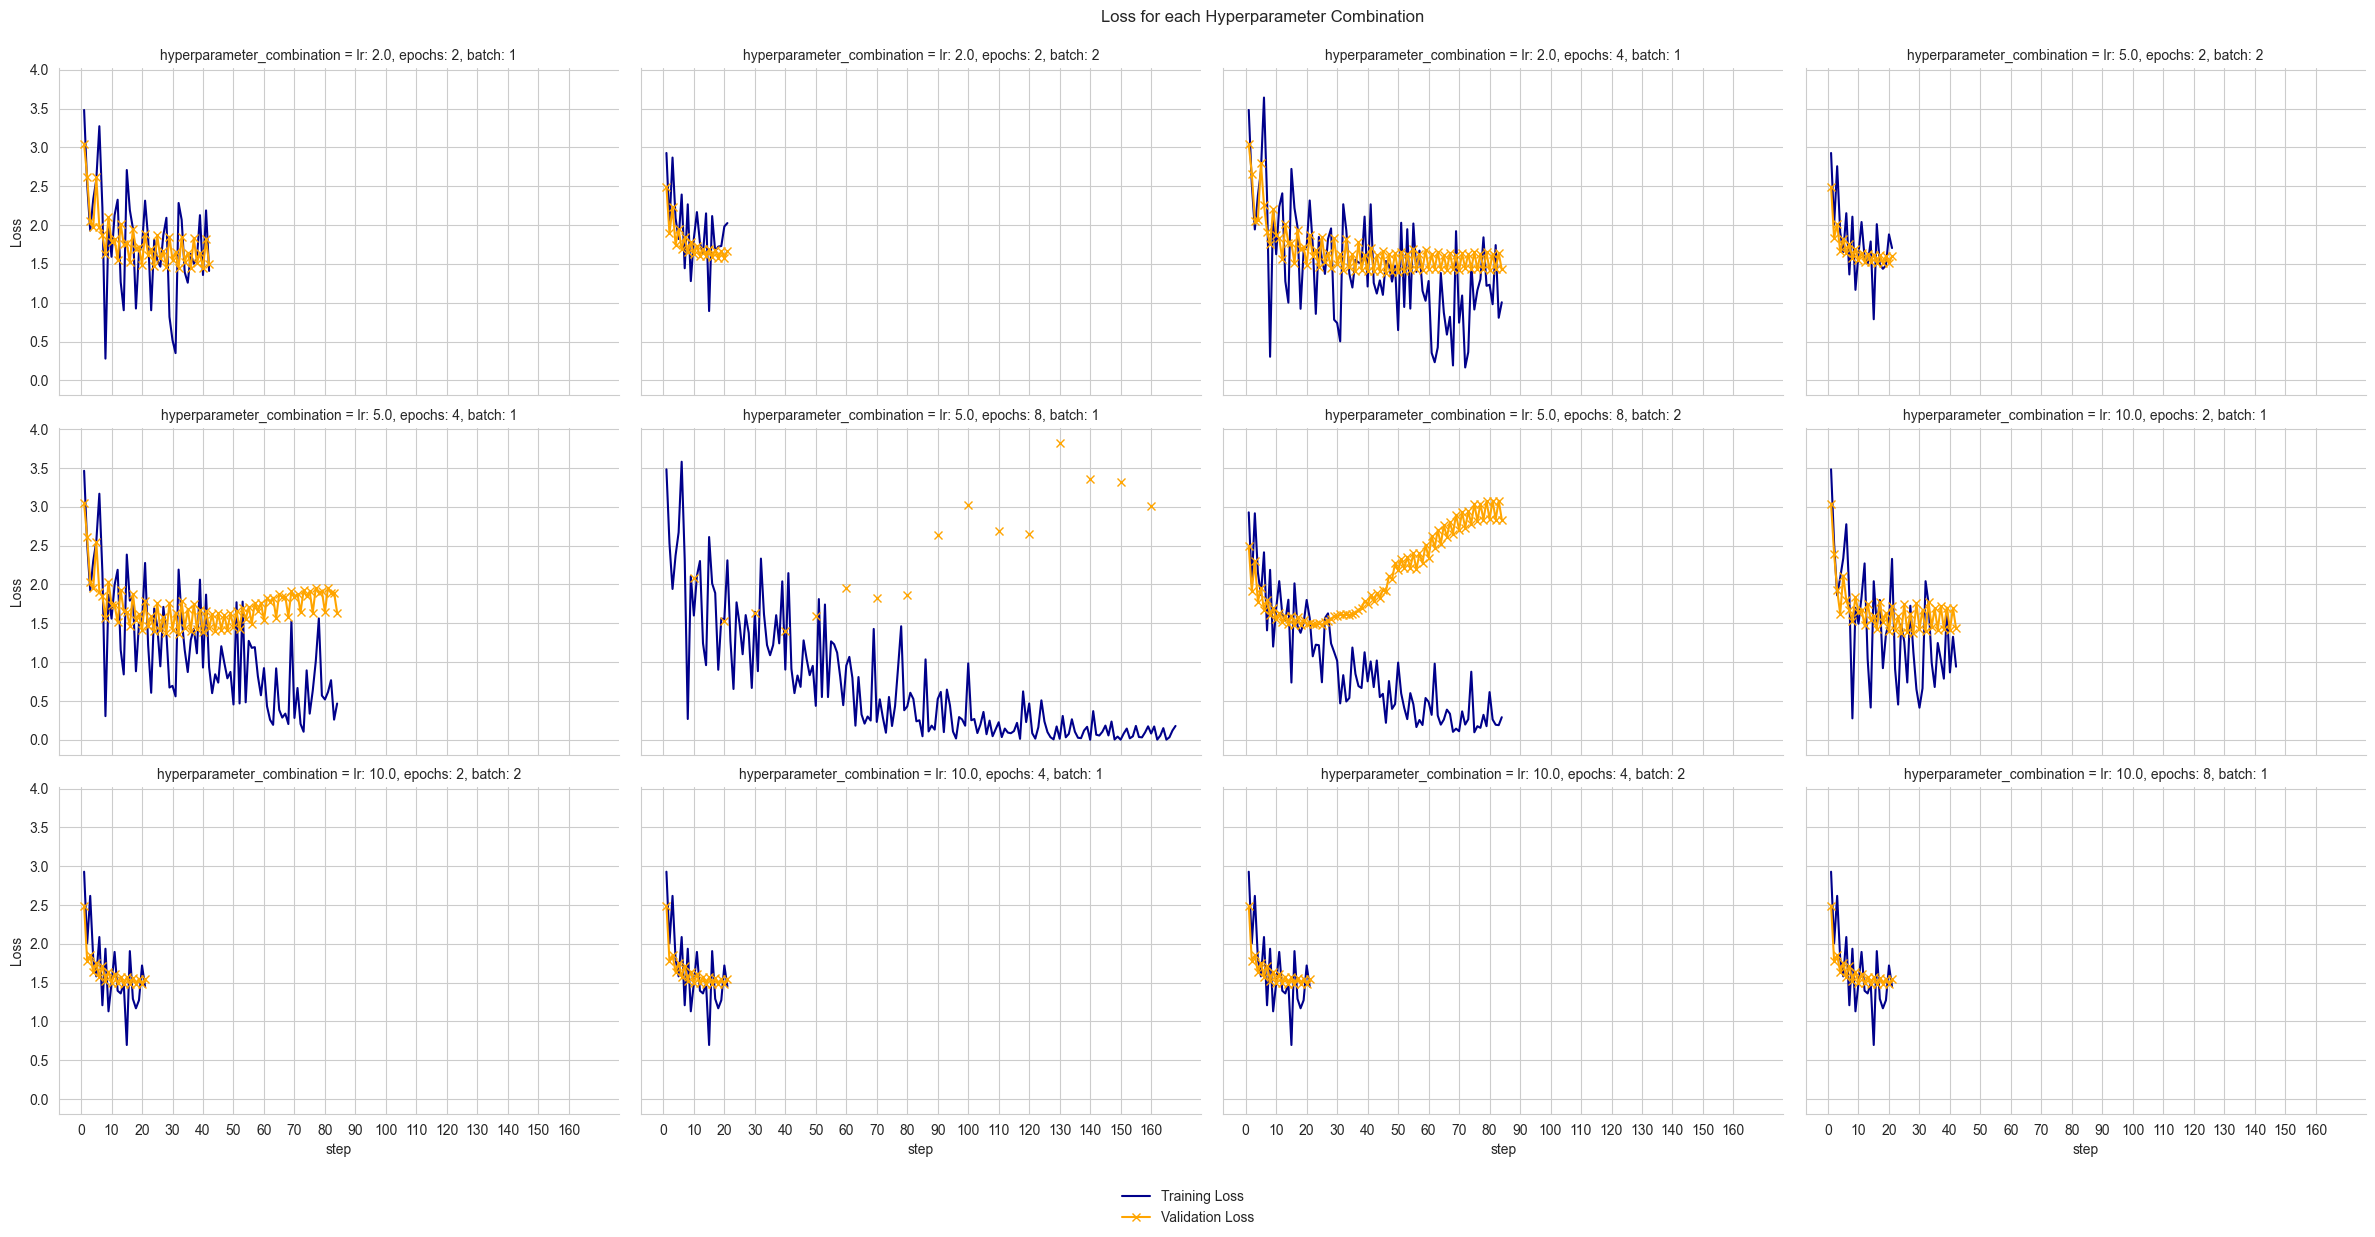

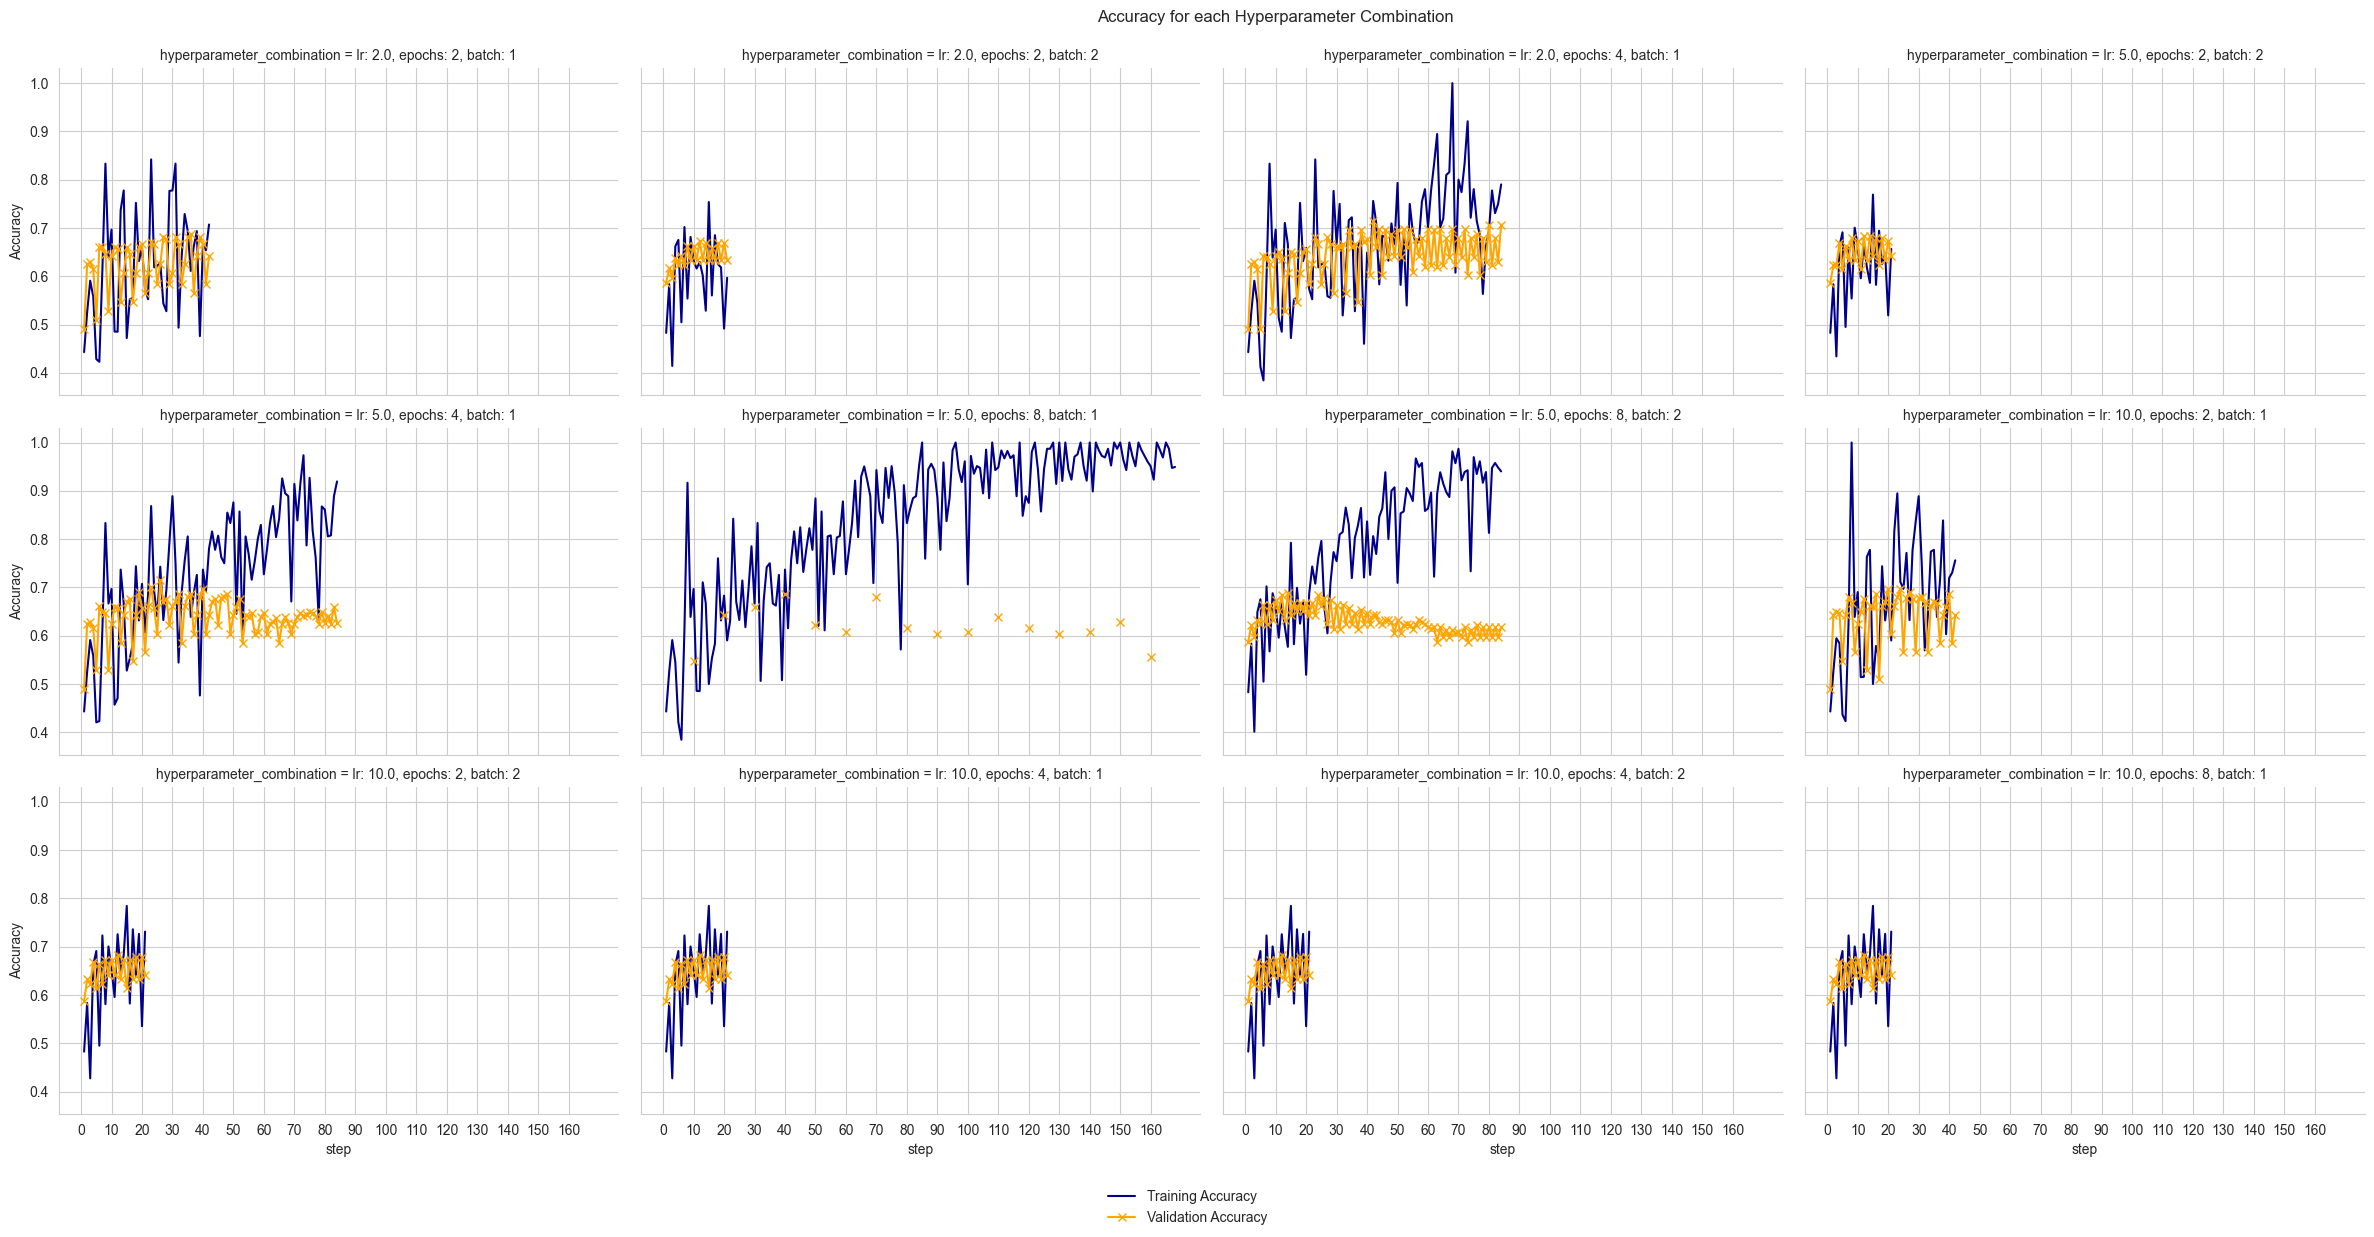

In [32]:
clas_results_metrics_copy = pd.read_csv("results/all_results_metrics.csv")
clas_results_metrics_copy["learning_rate_multiplier"] = clas_results_metrics_copy["learning_rate_multiplier"].astype(str)

# Create a column to represent each hyperparameter combination
clas_results_metrics_copy["hyperparameter_combination"] = (
    "lr: " + clas_results_metrics_copy["learning_rate_multiplier"].astype(str) +
    ", epochs: " + clas_results_metrics_copy["n_epochs"].astype(str) +
    ", batch: " + clas_results_metrics_copy["batch_size"].astype(str)
)

# delete rows where steps == =
clas_results_metrics_copy = clas_results_metrics_copy[clas_results_metrics_copy["step"] != "="]
clas_results_metrics_copy = clas_results_metrics_copy[clas_results_metrics_copy["step"] != "=="]
clas_results_metrics_copy = clas_results_metrics_copy[clas_results_metrics_copy["step"] != "==="]
# Convert steps to integers
clas_results_metrics_copy["step"] = clas_results_metrics_copy["step"].astype(int)

display(clas_results_metrics_copy.head())

# Plot the losses

sns.set_style("whitegrid") 
# grid of subplots: g with FacetGrid function
g = sns.FacetGrid(clas_results_metrics_copy,
                  col="hyperparameter_combination",
                  col_wrap=4,
                  height=4,
                  aspect=1.5
                  )
g.map(plt.plot, "step", "train_loss", label="Training Loss", color="darkblue")
g.map(plt.plot,
      "step",
      "valid_loss", 
      marker = "x",
      label="Validation Loss", 
      color="orange"
      )
g.add_legend(loc="lower center")
for ax in g.axes.flat:
    ax.set_ylabel("Loss")
    # display every tenth step on the x-axis
    ax.set_xticks(range(0, clas_results_metrics_copy["step"].max(), 10))
# Adjust the space at the bottom for the legend
g.figure.subplots_adjust(bottom=0.1)
g.figure.suptitle('Loss for each Hyperparameter Combination', y=1.02)
plt.show()


# Plot the accuracies
g = sns.FacetGrid(clas_results_metrics_copy, col="hyperparameter_combination", 
                  col_wrap=4, 
                  height=4, 
                  aspect=1.5,
                  margin_titles=True
                  )
g.map(plt.plot, 
      "step", 
      "train_accuracy", 
      label="Training Accuracy",
      color="darkblue"
      )
g.map(plt.plot, 
      "step", 
      "valid_mean_token_accuracy", 
      marker = "x", 
      label="Validation Accuracy", 
      color="orange"
      )
g.add_legend(loc="lower center")
for ax in g.axes.flat:
    ax.set_ylabel("Accuracy")
    # display every tenth step on the x-axis
    ax.set_xticks(range(0, clas_results_metrics_copy["step"].max(), 10))
# Adjust the space at the bottom for the legend
g.figure.subplots_adjust(bottom=0.1)
g.figure.suptitle('Accuracy for each Hyperparameter Combination', y=1.02)
plt.show()

# save all_results_metrics_copy as a global variable
clas_results_metrics_copy.to_csv("results/small_clas_results_metrics_copy.csv")

,Unnamed: 0,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,job_id,learning_rate_multiplier,n_epochs,batch_size,status,event_ids,result_file_name,hyperparameter_combination
171,0,1,3.46413,0.44304,3.04463,0.49057,ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE,5.0,4,1,succeeded,"['ftevent-nDnmI7lNiARlcM7kyJP380Zh', 'ftevent-...",['file-QS6nCcAK2kX9keQZ9cokwLG4'],"lr: 5.0, epochs: 4, batch: 1"
172,1,2,2.52395,0.52577,2.60508,0.62500,ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE,5.0,4,1,succeeded,"['ftevent-nDnmI7lNiARlcM7kyJP380Zh', 'ftevent-...",['file-QS6nCcAK2kX9keQZ9cokwLG4'],"lr: 5.0, epochs: 4, batch: 1"
173,2,3,1.92451,0.59091,2.03612,0.62887,ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE,5.0,4,1,succeeded,"['ftevent-nDnmI7lNiARlcM7kyJP380Zh', 'ftevent-...",['file-QS6nCcAK2kX9keQZ9cokwLG4'],"lr: 5.0, epochs: 4, batch: 1"
174,3,4,2.30411,0.55844,1.95472,0.61616,ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE,5.0,4,1,succeeded,"['ftevent-nDnmI7lNiARlcM7kyJP380Zh', 'ftevent-...",['file-QS6nCcAK2kX9keQZ9cokwLG4'],"lr: 5.0, epochs: 4, batch: 1"
175,4,5,2.55378,0.42063,2.54295,0.52830,ftjob-Pz4EHkQnN6QvYJ9zAvjpv9ZE,5.0,4,1,succeeded,"['ftevent-nDnmI7lNiARlcM7kyJP380Zh', 'ftevent-...",['file-QS6nCcAK2kX9keQZ9cokwLG4'],"lr: 5.0, epochs: 4, batch: 1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,163,164,0.14980,0.96907,NaN,NaN,ftjob-GTNZyACXSdOl9OWe9Klr6zwy,5.0,8,1,succeeded,"['ftevent-nJYLVdSWicD9E31GJHr4E9XJ', 'ftevent-...",['file-jGuK1aKyqeTbNwYZjmsy92sJ'],"lr: 5.0, epochs: 8, batch: 1"
419,164,165,0.00204,1.00000,NaN,NaN,ftjob-GTNZyACXSdOl9OWe9Klr6zwy,5.0,8,1,succeeded,"['ftevent-nJYLVdSWicD9E31GJHr4E9XJ', 'ftevent-...",['file-jGuK1aKyqeTbNwYZjmsy92sJ'],"lr: 5.0, epochs: 8, batch: 1"
420,165,166,0.03227,0.98710,NaN,NaN,ftjob-GTNZyACXSdOl9OWe9Klr6zwy,5.0,8,1,succeeded,"['ftevent-nJYLVdSWicD9E31GJHr4E9XJ', 'ftevent-...",['file-jGuK1aKyqeTbNwYZjmsy92sJ'],"lr: 5.0, epochs: 8, batch: 1"
421,166,167,0.11961,0.94737,NaN,NaN,ftjob-GTNZyACXSdOl9OWe9Klr6zwy,5.0,8,1,succeeded,"['ftevent-nJYLVdSWicD9E31GJHr4E9XJ', 'ftevent-...",['file-jGuK1aKyqeTbNwYZjmsy92sJ'],"lr: 5.0, epochs: 8, batch: 1"


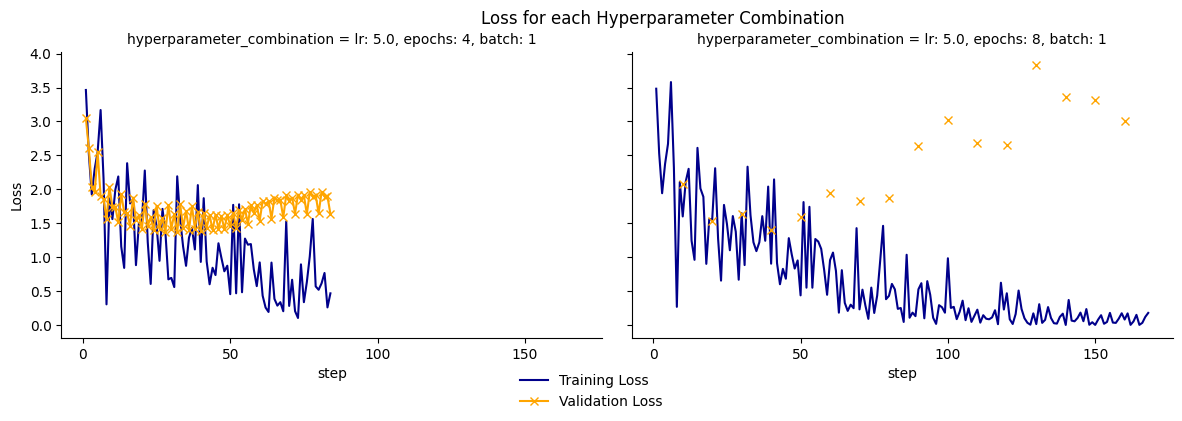

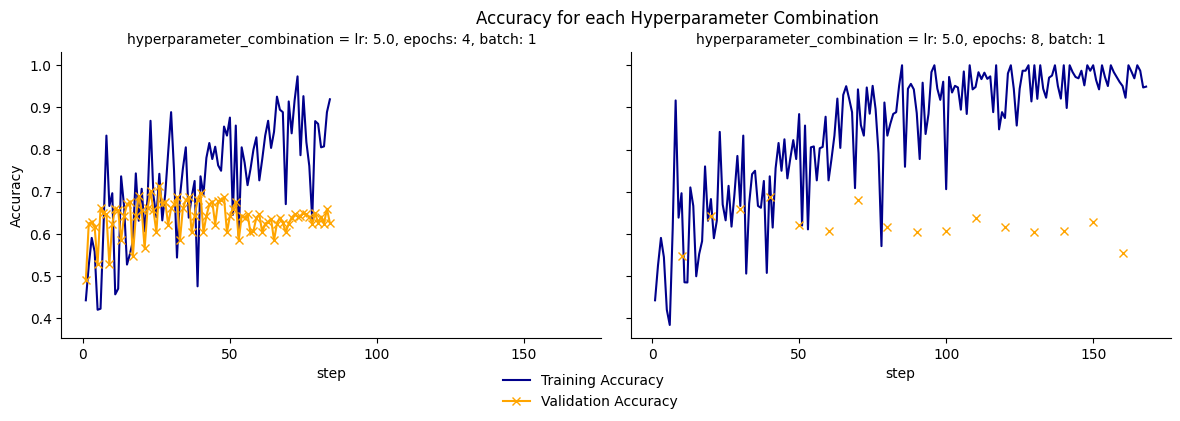

In [28]:
# from clas_results_metrics_copy filter all lines with hyperparameter combination lr:5, epochs=4, batch=1
# and save them in a new dataframe

# filter the dataframe
filter = clas_results_metrics_copy["hyperparameter_combination"] == "lr: 5.0, epochs: 4, batch: 1"
# add rows with lr: 5.0, epochs: 8, batch: 1 to a new dataframe
filter_2 = clas_results_metrics_copy["hyperparameter_combination"] == "lr: 5.0, epochs: 8, batch: 1"
# concatenate the two dataframes
filtered_df_1 = clas_results_metrics_copy[filter]
filtered_df_2 = clas_results_metrics_copy[filter_2]
filtered_df = pd.concat([filtered_df_1, filtered_df_2], axis=0)
display(filtered_df)

# Plot the losses with seaborn
# grid of subplots: g with FacetGrid function
g = sns.FacetGrid(filtered_df,
                  col="hyperparameter_combination",
                  col_wrap=2,
                  height=4,
                  aspect=1.5
                  )
g.map(plt.plot, "step", "train_loss", label="Training Loss", color="darkblue")
g.map(plt.plot,
      "step",
      "valid_loss", 
      marker = "x",
      label="Validation Loss", 
      color="orange"
      )
g.add_legend(loc="lower center")
for ax in g.axes.flat:
    ax.set_ylabel("Loss")
    # display every tenth step on the x-axis
    ax.set_xticks(range(0, filtered_df["step"].max(), 50))
# Adjust the space at the bottom for the legend
g.figure.subplots_adjust(bottom=0.2)
g.figure.suptitle('Loss for each Hyperparameter Combination', y=1.02)
plt.show()

# Plot the accuracies
g = sns.FacetGrid(filtered_df, col="hyperparameter_combination", 
                  col_wrap=2, 
                  height=4, 
                  aspect=1.5,
                  margin_titles=True
                  )
g.map(plt.plot, 
      "step", 
      "train_accuracy", 
      label="Training Accuracy",
      color="darkblue"
      )
g.map(plt.plot, 
      "step", 
      "valid_mean_token_accuracy", 
      marker = "x", 
      label="Validation Accuracy", 
      color="orange"
      )
g.add_legend(loc="lower center")
for ax in g.axes.flat:
    ax.set_ylabel("Accuracy")
    # display every tenth step on the x-axis
    ax.set_xticks(range(0, filtered_df["step"].max(), 50))
# Adjust the space at the bottom for the legend
g.figure.subplots_adjust(bottom=0.2)
g.figure.suptitle('Accuracy for each Hyperparameter Combination', y=1.02)
plt.show()



In [11]:
clas_results_metrics_copy = pd.read_csv("results/full_clas_results_metrics_copy.csv")

# Find three most minimal losses to choose the best model
min_loss = clas_results_metrics_copy["train_loss"].min()
min_losses = clas_results_metrics_copy["train_loss"].nsmallest(3)
#display(min_loss)
#display(min_losses)
print(f"Models {min_losses.index} are the models with the lowest losses of {min_losses.values}.")

# Find the model with the smallest training AND validation loss
# Calculate sum of each training and validation loss and find smallest sum
clas_results_metrics_copy["sum_loss"] = clas_results_metrics_copy["train_loss"] + clas_results_metrics_copy["valid_loss"]
min_sum_loss = clas_results_metrics_copy["sum_loss"].min()
min_sum_losses = clas_results_metrics_copy["sum_loss"].nsmallest(10)
display(min_sum_loss)
display(min_sum_losses)
print(f"Models {min_sum_losses.index} are the models with the lowest sum of training and validation losses of {min_sum_losses.values}.")

# Out of the three models with the smallest sum of losses,
# choose the one with the highest validation accuracy
max_valid_accuracy = clas_results_metrics_copy.loc[min_sum_losses.index, "valid_mean_token_accuracy"].max()
best_model = clas_results_metrics_copy.loc[min_sum_losses.index, "valid_mean_token_accuracy"].idxmax()
print(f"The best model is {best_model} with the highest validation accuracy of {max_valid_accuracy}.")

# save best model to a file
best_model_id = clas_results_metrics_copy.loc[best_model, "job_id"]
best_model_file = cbf.get_checkpoint_results(best_model_id)
with open("results/best_model.txt", "w") as f:
    f.write(best_model_file)

# print the data of the best model
display(clas_results_metrics_copy.loc[best_model])

# create a table with the ten best models based on the sum of losses, columns are losses and accuracies
best_models = clas_results_metrics_copy.loc[min_sum_losses.index]
best_models = best_models[["job_id", "train_loss", "valid_loss", "train_accuracy", "valid_mean_token_accuracy"]]
# set index to job_id
best_models.set_index("job_id", inplace=True)
display(best_models)

# save best_models to a file
best_models.to_csv("results/best_models.csv")


# # save min_sum_losses.index as list of indices
# min_sum_losses_indices = min_sum_losses.index.tolist()
# print(min_sum_losses_indices)
# display(clas_results_metrics_copy.loc[min_sum_losses_indices[0]])
# display(clas_results_metrics_copy.loc[min_sum_losses_indices[1]])
# display(clas_results_metrics_copy.loc[min_sum_losses_indices[2]])

Models Index([1197, 1430, 1155], dtype='int64') are the models with the lowest losses of [0.21901 0.24073 0.24161].


0.53436

619     0.53436
1396    0.54058
1406    0.54766
1151    0.55995
1161    0.55999
1201    0.56239
1171    0.56311
1376    0.56346
1426    0.56482
1436    0.56526
Name: sum_loss, dtype: float64

Models Index([619, 1396, 1406, 1151, 1161, 1201, 1171, 1376, 1426, 1436], dtype='int64') are the models with the lowest sum of training and validation losses of [0.53436 0.54058 0.54766 0.55995 0.55999 0.56239 0.56311 0.56346 0.56482
 0.56526].
The best model is 1151 with the highest validation accuracy of 0.93118.


INFO:cookbook_function:Decoded response content successfully.


Unnamed: 0.1                                                               1152
Unnamed: 0                                                                  259
step                                                                        260
train_loss                                                              0.28921
train_accuracy                                                          0.92171
valid_loss                                                              0.27074
valid_mean_token_accuracy                                               0.93118
job_id                                           ftjob-MWW3uqYEdflxMO1kCb40D8K4
learning_rate_multiplier                                                    6.0
n_epochs                                                                      3
batch_size                                                                   10
status                                                                succeeded
event_ids                     ['ftevent-

,train_loss,valid_loss,train_accuracy,valid_mean_token_accuracy
job_id,,,,
ftjob-GXjMS97heBGSRcXSj0a9eFvU,0.27403,0.26033,0.92500,0.92693
ftjob-ORbrKicdOcpRWKUqcFkhCwKG,0.26207,0.27851,0.93056,0.92768
ftjob-ORbrKicdOcpRWKUqcFkhCwKG,0.26384,0.28382,0.92222,0.92634
ftjob-MWW3uqYEdflxMO1kCb40D8K4,0.28921,0.27074,0.92171,0.93118
ftjob-MWW3uqYEdflxMO1kCb40D8K4,0.27664,0.28335,0.92708,0.92596
ftjob-MWW3uqYEdflxMO1kCb40D8K4,0.28800,0.27439,0.92500,0.92805
ftjob-MWW3uqYEdflxMO1kCb40D8K4,0.27747,0.28564,0.92909,0.92292
ftjob-ORbrKicdOcpRWKUqcFkhCwKG,0.27163,0.29183,0.93041,0.92136
ftjob-ORbrKicdOcpRWKUqcFkhCwKG,0.27200,0.29282,0.92618,0.92206


Model with job_id ftjob-ORbrKicdOcpRWKUqcFkhCwKG has the smallest training loss and validation loss.
Model name: ft:gpt-3.5-turbo-0125:lse:full-clas:9rvMyWm6

In [48]:
# print smallest sum of losses of models with combination lr: 5, epochs: 4, batch: 1
display(clas_results_metrics_copy[clas_results_metrics_copy["hyperparameter_combination"] == "lr: 2.0, epochs: 3, batch: 5"])


,Unnamed: 0.1,Unnamed: 0,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy,job_id,learning_rate_multiplier,n_epochs,batch_size,status,event_ids,result_file_name,hyperparameter_combination,sum_loss
0,0,0,1,1.17031,0.83716,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"['ftevent-GciKljCvMLYOraVpitXaJX0o', 'ftevent-...",['file-ejv9IqQI5yX73RvJJuiD4ZdB'],"lr: 2.0, epochs: 3, batch: 5",NaN
1,1,1,2,1.21950,0.83125,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"['ftevent-GciKljCvMLYOraVpitXaJX0o', 'ftevent-...",['file-ejv9IqQI5yX73RvJJuiD4ZdB'],"lr: 2.0, epochs: 3, batch: 5",NaN
2,2,2,3,1.17913,0.83090,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"['ftevent-GciKljCvMLYOraVpitXaJX0o', 'ftevent-...",['file-ejv9IqQI5yX73RvJJuiD4ZdB'],"lr: 2.0, epochs: 3, batch: 5",NaN
3,3,3,4,1.33740,0.82708,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"['ftevent-GciKljCvMLYOraVpitXaJX0o', 'ftevent-...",['file-ejv9IqQI5yX73RvJJuiD4ZdB'],"lr: 2.0, epochs: 3, batch: 5",NaN
4,4,4,5,1.17427,0.82463,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"['ftevent-GciKljCvMLYOraVpitXaJX0o', 'ftevent-...",['file-ejv9IqQI5yX73RvJJuiD4ZdB'],"lr: 2.0, epochs: 3, batch: 5",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,664,664,665,0.27132,0.92500,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"['ftevent-GciKljCvMLYOraVpitXaJX0o', 'ftevent-...",['file-ejv9IqQI5yX73RvJJuiD4ZdB'],"lr: 2.0, epochs: 3, batch: 5",NaN
665,665,665,666,0.31801,0.92500,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"['ftevent-GciKljCvMLYOraVpitXaJX0o', 'ftevent-...",['file-ejv9IqQI5yX73RvJJuiD4ZdB'],"lr: 2.0, epochs: 3, batch: 5",NaN
666,666,666,667,0.26017,0.93125,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"['ftevent-GciKljCvMLYOraVpitXaJX0o', 'ftevent-...",['file-ejv9IqQI5yX73RvJJuiD4ZdB'],"lr: 2.0, epochs: 3, batch: 5",NaN
667,667,667,668,0.31592,0.92693,NaN,NaN,ftjob-GXjMS97heBGSRcXSj0a9eFvU,2.0,3,5,succeeded,"['ftevent-GciKljCvMLYOraVpitXaJX0o', 'ftevent-...",['file-ejv9IqQI5yX73RvJJuiD4ZdB'],"lr: 2.0, epochs: 3, batch: 5",NaN


Cancel or track a fine-tune job or delete a model

In [ ]:
# # List 10 fine-tuning jobs
# client.fine_tuning.jobs.list(limit=10)

# # Retrieve the state of a fine-tune
# client.fine_tuning.jobs.retrieve("ftjob-abc123")

# # Cancel a job
# client.fine_tuning.jobs.cancel("ftjob-abc123")

# # List up to 10 events from a fine-tuning job
# client.fine_tuning.jobs.list_events(fine_tuning_job_id="ftjob-abc123", limit=10)

# # Delete a fine-tuned model (must be an owner of the org the model was created in)
# client.models.delete("ft:gpt-3.5-turbo:acemeco:suffix:abc123")

Using fine-tuned model via Playground or via code

In [7]:
# save json small test set in a list of messages
test_messages = []
with open("data/finetuning_data/testing_data_messages.jsonl", "r") as f:
    for line in f:
        test_messages.append(json.loads(line))

# make a request to the new model
for i in range(len(test_messages)):
    completion = client.chat.completions.create(
        model="ft:gpt-3.5-turbo-0125:lse:full-clas:9rvMyWm6",
        messages = test_messages[i]["messages"]
        )
    print(completion.choices[0].message)
    # save the response in a list
    test_messages[i]["messages"].append({"role":"response"})
    test_messages[i]["messages"].append({"content": completion.choices[0].message.content})

# save the responses in a jsonl file
with open("data/finetuning_data/full_clas_testing_data_responses.jsonl", "w") as f:
    for message in test_messages:
        f.write(json.dumps(message) + "\n")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 8178EP8, ECR%:0.771, EPP%:0.905, EFD/IDG%:0.229, Greens/EFA%:0.98, NI%:0.192, REG%:0.925, S&D%:0.937, The Left%:0.827, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 10214EP8, ECR%:0.729, EPP%:0.812, EFD/IDG%:0.208, Greens/EFA%:1.0, NI%:0.154, REG%:0.806, S&D%:0.874, The Left%:0.269, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5956EP7, ECR%:0.298, EPP%:0.828, EFD/IDG%:0.29, Greens/EFA%:0.018, NI%:0.091, REG%:0.759, S&D%:0.856, The Left%:0.029, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6522EP7, ECR%:0.246, EPP%:0.854, EFD%:0.355, Greens/EFA%:0.86, NI%:0.364, REG%:0.831, S%:0.831, The Left%:0.0, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 712EP7, ECR%:0.333, EPP%:0.634, EFD/IDG%:0.581, Greens/EFA%:0.386, NI%:0.303, REG%:0.614, S&D%:0.603, The Left%:0.571, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6836EP7, ECR%:0.07, EPP%:0.902, EFD/IDG%:0.484, Greens/EFA%:0.93, NI%:0.364, REG%:0.891, S&D%:0.881, The Left%:0.314, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 9408EP8, ECR%:0.886, EPP%:0.955, EFD/IDG%:0.979, Greens/EFA%:0.9, NI%:0.269, REG%:0.955, S&D%:0.929, The Left%:0.077, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 2011EP7, ECR%:0.965, EPP%:0.912, EFD/IDG%:0.581, Greens/EFA%:0.982, NI%:0.515, REG%:0.916, S&D%:0.897, The Left%:0.829, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6796EP7, ECR%:0.842, EPP%:0.886, EFD/IDG%:0.484, Greens/EFA%:0.018, NI%:0.424, REG%:0.831, S&D%:0.856, The Left%:0.8, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 10924EP9, ECR%:0.184, EPP%:0.873, EFD/IDG%:0.877, Greens/EFA%:0.946, NI%:0.316, REG%:0.94, S&D%:0.805, The Left%:0.659, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 10206EP8, ECR%:0.629, EPP%:0.821, EFD/IDG%:0.729, Greens/EFA%:0.74, NI%:0.25, REG%:0.91, S%:0.776, The Left%:0.25, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 836EP9, ECR%:0.065, EPP%:0.827, EFD/IDG%:0.0, Greens/EFA%:0.757, NI%:0.316, REG%:0.838, S&D%:0.701, The Left%:0.049, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5148EP7, ECR%:0.579, EPP%:0.726, EFD/IDG%:0.323, Greens/EFA%:0.825, NI%:0.333, REG%:0.759, S&D%:0.738, The Left%:0.657, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 843EP7, ECR%:0.842, EPP%:0.874, EFD/IDG%:0.548, Greens/EFA%:0.056, NI%:0.152, REG%:0.831, S&D%:0.751, The Left%:0.114, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 1099EP7, ECR%:0.474, EPP%:0.69, EFD/IDG%:0.323, Greens/EFA%:0.895, NI%:0.424, REG%:0.722, S&D%:0.805, The Left%:0.714, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 7654EP8, ECR%:0.014, EPP%:0.755, EFD/IDG%:0.708, Greens/EFA%:0.96, NI%:0.077, REG%:0.88, S&D%:0.856, The Left%:0.846, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6939EP8, ECR%:0.871, EPP%:0.846, EFD/IDG%:0.229, Greens/EFA%:0.98, NI%:0.154, REG%:0.925, S&D%:0.885, The Left%:0.942, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 811EP8, ECR%:0.9, EPP%:0.937, EFD/IDG%:0.562, Greens/EFA%:1.0, NI%:0.269, REG%:0.91, S&D%:0.928, The Left%:0.808, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5849EP8, ECR%:0.829, EPP%:0.886, EFD/IDG%:0.813, Greens/EFA%:0.02, NI%:0.154, REG%:0.866, S&D%:0.013, The Left%:0.038, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 7476EP8, ECR%:0.686, EPP%:0.85, EFD/IDG%:0.458, Greens/EFA%:0.98, NI%:0.212, REG%:0.836, S%:0.951, The Left%:0.731, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 1439EP9, ECR%:0.847, EPP%:0.822, EFD/IDG%:0.603, Greens/EFA%:0.0, NI%:0.316, REG%:0.78, S%:0.049, The Left%:0.0, General Majority:0, Left Majority:0, Right Majority:1, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5278EP9, ECR%:0.613, EPP%:0.871, EFD/IDG%:0.356, Greens/EFA%:0.905, NI%:0.544, REG%:0.885, S%:0.851, The Left%:0.829, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6126EP9, ECR%:0.758, EPP%:0.836, EFD/IDG%:0.329, Greens/EFA%:0.851, NI%:0.333, REG%:0.796, S%:0.769, The Left%:0.61, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 7452EP8, ECR%:0.786, EPP%:0.828, EFD/IDG%:0.688, Greens/EFA%:0.9, NI%:0.115, REG%:0.896, S&D%:0.832, The Left%:0.75, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 10759EP9, ECR%:0.952, EPP%:0.934, EFD/IDG%:0.603, Greens/EFA%:0.919, NI%:0.596, REG%:0.944, S&D%:0.903, The Left%:0.902, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 3580EP8, ECR%:0.614, EPP%:0.748, EFD/IDG%:0.688, Greens/EFA%:0.78, NI%:0.154, REG%:0.836, S&D%:0.799, The Left%:0.808, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 4491EP8, ECR%:0.629, EPP%:0.896, EFD/IDG%:0.354, Greens/EFA%:0.94, NI%:0.077, REG%:0.955, S&D%:0.89, The Left%:0.885, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 3437EP7, ECR%:0.702, EPP%:0.675, EFD%:0.548, Greens/EFA%:1.018, NI%:0.394, REG%:0.675, S&D%:0.743, The Left%:0.057, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 3298EP7, ECR%:0.86, EPP%:0.816, EFD/IDG%:0.742, Greens/EFA%:0.035, NI%:0.333, REG%:0.795, S&D%:0.815, The Left%:0.2, General Majority:1, Left Majority:0, Right Majority:1, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 2103EP7, ECR%:0.702, EPP%:0.737, EFD/IDG%:0.548, Greens/EFA%:0.684, NI%:0.455, REG%:0.771, S&D%:0.738, The Left%:0.0, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 558EP7, ECR%:0.421, EPP%:0.873, EFD/IDG%:0.581, Greens/EFA%:0.684, NI%:0.455, REG%:0.831, S&D%:0.718, The Left%:0.714, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 152EP7, ECR%:0.895, EPP%:0.853, EFD/IDG%:0.161, Greens/EFA%:0.842, NI%:0.242, REG%:0.916, S%:0.877, The Left%:0.0, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 9530EP8, ECR%:0.743, EPP%:0.843, EFD/IDG%:0.333, Greens/EFA%:0.92, NI%:0.173, REG%:0.925, S%:0.91, The Left%:1.0, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6414EP7, ECR%:0.719, EPP%:0.883, EFD/IDG%:0.613, Greens/EFA%:0.895, NI%:0.424, REG%:0.888, S&D%:0.856, The Left%:0.8, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 4312EP9, ECR%:0.661, EPP%:0.778, EFD/IDG%:0.822, Greens/EFA%:0.0, NI%:0.491, REG%:0.944, S&D%:0.319, The Left%:0.098, General Majority:0, Left Majority:0, Right Majority:1, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 4152EP7, ECR%:0.877, EPP%:0.82, EFD/IDG%:0.613, Greens/EFA%:0.842, NI%:0.697, REG%:0.862, S&D%:0.805, The Left%:0.771, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 1930EP9, ECR%:1.016, EPP%:0.956, EFD/IDG%:0.836, Greens/EFA%:0.919, NI%:0.632, REG%:0.935, S&D%:0.916, The Left%:0.902, General Majority:1, Left Majority:0, Right Majority:0, Consensus:1', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5657EP7, ECR%:0.0, EPP%:0.81, EFD%:0.0, Greens/EFA%:0.07, NI%:0.03, REG%:0.843, S%:0.835, The Left%:0.0, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6919EP7, ECR%:0.74, EPP%:0.828, EFD/IDG%:0.226, Greens/EFA%:0.88, NI%:0.333, REG%:0.831, S&D%:0.805, The Left%:0.8, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 500 Internal Server Error"
INFO:openai._base_client:Retrying request to /chat/completions in 0.966671 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 459EP9, ECR%:1.032, EPP%:0.942, EFD/IDG%:0.877, Greens/EFA%:0.757, NI%:0.649, REG%:0.944, S&D%:0.865, The Left%:0.366, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6154EP7, ECR%:0.368, EPP%:0.828, EFD/IDG%:0.452, Greens/EFA%:0.947, NI%:0.182, REG%:0.902, S&D%:0.877, The Left%:0.857, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 1426EP7, ECR%:0.807, EPP%:0.853, EFD/IDG%:0.419, Greens/EFA%:0.965, NI%:0.697, REG%:0.916, S&D%:0.862, The Left%:0.829, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 12416EP9, ECR%:0.968, EPP%:0.956, EFD/IDG%:0.616, Greens/EFA%:0.946, NI%:0.606, REG%:0.935, S%:0.745, S&D%:0.917, The Left%:0.83, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 3714EP7, ECR%:0.053, EPP%:0.932, EFD/IDG%:0.548, Greens/EFA%:0.86, NI%:0.364, REG%:0.94, S&D%:0.851, The Left%:0.029, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 228EP8, ECR%:0.743, EPP%:0.806, EFD/IDG%:0.75, Greens/EFA%:0.78, NI%:0.154, REG%:0.955, S&D%:0.848, The Left%:0.615, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 13234EP9, ECR%:0.855, EPP%:0.923, EFD/IDG%:0.603, Greens/EFA%:0.892, NI%:0.561, REG%:0.944, S&D%:0.843, The Left%:0.756, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 4257EP7, ECR%:0.754, EPP%:0.875, EFD/IDG%:0.548, Greens/EFA%:0.93, NI%:0.303, REG%:0.952, S&D%:0.897, The Left%:0.771, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 1148EP8, ECR%:0.957, EPP%:0.896, EFD%:0.354, Greens/EFA%:0.98, NI%:0.077, REG%:0.97, S&D%:0.906, The Left%:0.0, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6803EP7, ECR%:0.901, EPP%:0.877, EFD/IDG%:0.65, Greens/EFA%:0.912, NI%:0.485, REG%:0.88, S&D%:0.863, The Left%:0.057', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6579EP9, ECR%:1.0, EPP%:0.967, EFD/IDG%:0.849, Greens/EFA%:0.919, NI%:0.667, REG%:0.944, S&D%:0.909, The Left%:0.78, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 3593EP7, ECR%:0.754, EPP%:0.817, EFD/IDG%:0.258, Greens/EFA%:0.86, NI%:0.273, REG%:0.892, S%:0.912, The Left%:0.6, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 4328EP7, ECR%:0.298, EPP%:0.861, EFD%:0.452, Greens/EFA%:0.912, NI%:0.455, REG%:0.904, S%:0.882, The Left%:0.743, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5701EP7, ECR%:0.719, EPP%:0.805, EFD%:0.516, Greens/EFA%:0.825, NI%:0.424, REG%:0.747, S&D%:0.779, The Left%:0.714, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5318EP7, ECR%:0.193, EPP%:0.891, EFD/IDG%:0.613, Greens/EFA%:0.86, NI%:0.394, REG%:0.892, S&D%:0.856, The Left%:0.8, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 7686EP8, ECR%:0.243, EPP%:0.836, EFD/EGF%:0.833, Greens/EFA%:0.78, NI%:0.192, REG%:0.925, S&D%:0.859, The Left%:0.75, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 2134EP8, ECR%:0.871, EPP%:0.941, EFD/IDG%:0.354, Greens/EFA%:0.88, NI%:0.173, REG%:0.925, S&D%:0.911, The Left%:0.808, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 716EP7, ECR%:0.789, EPP%:0.851, EFD/IDG%:0.645, Greens/EFA%:0.93, NI%:0.364, REG%:0.892, S&D%:0.841, The Left%:0.829, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 7192EP8, ECR%:0.657, EPP%:0.8, EFD/IDG%:0.479, Greens/EFA%:0.86, NI%:0.173, REG%:0.851, S&D%:0.766, The Left%:0.731, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6772EP7, ECR%:0.684, EPP%:0.768, EFD/IDG%:0.581, Greens/EFA%:0.737, NI%:0.394, REG%:0.711, S&D%:0.728, The Left%:0.657, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 11399EP9, ECR%:0.871, EPP%:0.841, EFD/IDG%:0.521, Greens/EFA%:0.946, NI%:0.544, REG%:0.916, S&D%:0.851, The Left%:0.829, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 2163EP7, ECR%:0.37, EPP%:0.579, EFD/IDG%:0.097, Greens/EFA%:0.105, NI%:0.03, REG%:0.157, S&D%:0.495, The Left%:0.057, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 881EP9, ECR%:1.032, EPP%:0.962, EFD/IDG%:0.945, Greens/EFA%:0.784, NI%:0.632, REG%:0.944, S%:0.902, The Left%:0.756, General Majority:1, Left Majority:0, Right Majority:1, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 2823EP8, ECR%:0.871, EPP%:0.908, EFD/IDG%:1.979, Greens/EFA%:0.92, NI%:0.231, REG%:0.925, S&D%:0.937, The Left%:0.788, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 8308EP8, ECR%:0.729, EPP%:0.869, EFD/IDG%:0.5, Greens/EFA%:0.04, NI%:0.135, REG%:0.806, S%:0.821, The Left%:0.038, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 4634EP8, ECR%:0.9, EPP%:0.891, EFD/IDG%:0.854, Greens/EFA%:1.0, NI%:0.154, REG%:0.925, S%:0.896, The Left%:0.827, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 150EP7, ECR%:0.807, EPP%:0.865, EFD/IDG%:0.452, Greens/EFA%:0.86, NI%:0.364, REG%:0.795, S&D%:0.882, The Left%:0.829, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 9443EP8, ECR%:0.9, EPP%:0.919, EFD/IDG%:0.875, Greens/EFA%:0.92, NI%:0.269, REG%:0.97, S%:0.864, The Left%:0.135, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 4157EP7, ECR%:0.088, EPP%:0.9, EFD/IDG%:0.419, Greens/EFA%:0.912, NI%:0.333, REG%:0.855, S&D%:0.872, The Left%:0.857, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 3260EP9, ECR%:0.984, EPP%:0.962, EFD/IDG%:0.644, Greens/EFA%:0.068, NI%:0.526, REG%:0.944, S&D%:0.817, The Left%:0.0, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 1777EP7, ECR%:0.684, EPP%:0.775, EFD/IDG%:0.581, Greens/EFA%:0.86, NI%:0.485, REG%:0.699, S%:0.704, The Left%:0.571, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 3588EP7, ECR%:0.158, EPP%:0.797, EFD/IDG%:0.29, Greens/EFA%:0.825, NI%:0.242, REG%:0.783, S&D%:0.79, The Left%:0.743, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5887EP7, ECR%:0.649, EPP%:0.791, EFD%:0.516, Greens/EFA%:0.0, NI%:0.182, REG%:0.855, S%:0.718, The Left%:0.057, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 8045EP8, ECR%:0.0, EPP%:0.733, EFD/IDG%:0.062, Greens/EFA%:0.88, NI%:0.096, REG%:0.82, S&D%:0.785, The Left%:0.712, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5606EP7, ECR%:0.456, EPP%:0.572, EFD%:0.194, Greens/EFA%:0.895, NI%:0.273, REG%:0.325, S&D%:0.628, The Left%:0.114, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 3247EP8, ECR%:0.871, EPP%:0.962, EFD/IDG%:0.875, Greens/EFA%:0.98, NI%:0.25, REG%:0.925, S&D%:0.932, The Left%:0.846, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5009EP8, ECR%:0.186, EPP%:0.848, EFD/IDG%:0.979, Greens/EFA%:0.94, NI%:0.231, REG%:0.836, S&D%:0.866, The Left%:0.865, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 635EP7, ECR%:0.439, EPP%:0.562, EFD/IDG%:0.516, Greens/EFA%:0.807, NI%:0.394, REG%:0.723, S&D%:0.62, The Left%:0.6, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6153EP8, ECR%:0.557, EPP%:0.062, EFD/IDG%:0.271, Greens/EFA%:0.92, NI%:0.115, REG%:0.925, S&D%:0.878, The Left%:0.788, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 2759EP7, ECR%:0.246, EPP%:0.681, EFD/IDG%:0.258, Greens/EFA%:0.754, NI%:0.182, REG%:0.699, S&D%:0.723, The Left%:0.743, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 1441EP9, ECR%:0.016, EPP%:0.822, EFD/IDG%:0.055, Greens/EFA%:0.905, NI%:0.254, REG%:0.854, S&D%:0.683, The Left%:0.634, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6082EP7, ECR%:0.93, EPP%:0.88, EFD/IDG%:0.61, Greens/EFA%:0.93, NI%:0.394, REG%:0.88, S&D%:0.897, The Left%:0.857, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5898EP7, ECR%:0.509, EPP%:0.825, EFD/IDG%:0.387, Greens/EFA%:0.93, NI%:0.242, REG%:0.747, S&D%:0.846, The Left%:0.771, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6199EP8, ECR%:0.871, EPP%:0.896, EFD/IDG%:0.5, Greens/EFA%:0.94, NI%:0.135, REG%:0.925, S&D%:0.927, The Left%:0.865, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 10204EP8, ECR%:0.771, EPP%:0.869, EFD/IDG%:0.521, Greens/EFA%:0.9, NI%:0.231, REG%:0.985, S%:0.91, The Left%:0.808, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5984EP7, ECR%:0.491, EPP%:0.74, EFD/IDG%:0.226, Greens/EFA%:0.912, NI%:0.273, REG%:0.735, S&D%:0.769, The Left%:0.4, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5166EP8, ECR%:0.871, EPP%:0.891, EFD/IDG%:0.583, Greens/EFA%:0.86, NI%:0.154, REG%:0.925, S&D%:0.885, The Left%:0.692, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 2290EP7, ECR%:0.947, EPP%:0.922, EFD/IDG%:0.613, Greens/EFA%:0.912, NI%:0.515, REG%:0.892, S&D%:0.897, The Left%:0.771, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 2394EP9, ECR%:0.984, EPP%:0.956, EFD/IDG%:0.589, Greens/EFA%:0.946, NI%:0.579, REG%:0.926, S&D%:0.909, The Left%:0.829, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 3523EP8, ECR%:0.771, EPP%:0.82, EFD/IDG%:0.875, Greens/EFA%:1.0, NI%:0.154, REG%:0.925, S&D%:0.791, The Left%:0.808, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 3922EP8, ECR%:0.814, EPP%:0.732, EFD/IDG%:0.917, Greens/EFA%:0.02, NI%:0.077, REG%:0.88, S&D%:0.74, The Left%:0.019, General Majority:1, Left Majority:0, Right Majority:1, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 9488EP8, ECR%:0.829, EPP%:0.78, EFD/IDG%:0.771, Greens/EFA%:0.84, NI%:0.212, REG%:0.866, S&D%:0.802, The Left%:0.808, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 3801EP8, ECR%:0.771, EPP%:0.778, EFD/IDG%:0.542, Greens/EFA%:0.76, NI%:0.154, REG%:0.806, S&D%:0.773, The Left%:0.519', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 1079EP7, ECR%:0.526, EPP%:0.662, EFD/IDG%:0.581, Greens/EFA%:0.86, NI%:0.333, REG%:0.747, S&D%:0.795, The Left%:0.771, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 8000EP9, ECR%:0.823, EPP%:0.951, EFD/IDG%:0.356, Greens/EFA%:0.0, NI%:0.351, REG%:0.954, S&D%:0.659, The Left%:0.0, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 2015EP7, ECR%:0.93, EPP%:0.867, EFD/IDG%:0.323, Greens/EFA%:0.93, NI%:0.424, REG%:0.964, S&D%:0.841, The Left%:0.914, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 3577EP7, ECR%:0.842, EPP%:0.897, EFD/IDG%:0.548, Greens/EFA%:0.035, NI%:0.242, REG%:0.759, S&D%:0.769, The Left%:0.0, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 4451EP8, ECR%:0.786, EPP%:0.828, EFD/IDG%:0.333, Greens/EFA%:0.9, NI%:0.115, REG%:0.806, S&D%:0.859, The Left%:0.519, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6423EP7, ECR%:0.684, EPP%:0.897, EFD/IDG%:0.581, Greens/EFA%:0.877, NI%:0.394, REG%:0.892, S&D%:0.897, The Left%:0.743, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6103EP7, ECR%:0.702, EPP%:0.853, EFD%:0.484, Greens/EFA%:0.895, IDG%:0.697, NI%:0.515, REG%:0.831, S%:0.877, The Left%:0.8, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 7447EP8, ECR%:0.029, EPP%:0.088, EFD/IDG%:0.875, Greens/EFA%:0.0, NI%:0.115, REG%:0.09, S&D%:0.023, The Left%:0.0, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 1082EP7, ECR%:0.351, EPP%:0.649, EFD/IDG%:0.226, Greens/EFA%:0.754, NI%:0.424, REG%:0.759, S&D%:0.672, The Left%:0.543, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 2588EP8, ECR%:0.014, EPP%:0.828, EFD/IDG%:0.021, Greens/EFA%:0.98, NI%:0.115, REG%:0.925, S%:0.875, The Left%:0.885, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5989EP7, ECR%:0.825, EPP%:0.817, EFD/IDG%:0.419, Greens/EFA%:0.86, NI%:0.303, REG%:0.831, S&D%:0.738, The Left%:0.171, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 4720EP8, ECR%:0.9, EPP%:0.88, EFD/IDG%:1.875, Greens/EFA%:0.94, NI%:0.192, REG%:0.925, S&D%:0.885, The Left%:0.865, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5306EP7, ECR%:0.246, EPP%:0.584, EFD/IDG%:0.29, Greens/EFA%:0.07, NI%:0.152, REG%:0.494, S&D%:0.492, The Left%:0.2, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 564EP8, ECR%:0.4, EPP%:0.846, EFD/IDG%:0.396, Greens/EFA%:0.9, NI%:0.154, REG%:0.925, S&D%:0.791, The Left%:0.731, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 2137EP8, ECR%:0.814, EPP%:0.871, EFD/IDG%:0.875, Greens/EFA%:0.76, NI%:0.135, REG%:0.925, S&D%:0.903, The Left%:0.885, General majority:1, Left majority:0, Right majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 7453EP8, ECR%:0.829, EPP%:0.873, EFD/IDG%:0.708, Greens/EFA%:0.06, NI%:0.173, REG%:0.91, S&D%:0.851, The Left%:0.635, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 9032EP8, ECR%:0.943, EPP%:0.937, EFD/IDG%:0.958, Greens/EFA%:0.98, NI%:0.192, REG%:0.925, S&D%:0.932, The Left%:0.885, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5658EP7, ECR%:0.684, EPP%:0.872, EFD/IDG%:0.645, Greens/EFA%:0.912, NI%:0.515, REG%:0.88, S%:0.892, The Left%:0.829, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 2952EP7, ECR%:0.263, EPP%:0.853, EFD/IDG%:0.194, Greens/EFA%:0.86, NI%:0.212, REG%:0.867, S&D%:0.887, The Left%:0.314, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 10711EP9, ECR%:0.935, EPP%:0.948, EFD/IDG%:0.822, Greens/EFA%:0.959, NI%:0.632, REG%:0.954, S&D%:0.922, The Left%:0.854, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 9270EP8, ECR%:0.571, EPP%:0.747, EFD%:0.104, Greens/EFA%:0.98, NI%:0.192, REG%:0.925, S&D%:0.853, The Left%:0.692, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 4000EP7, ECR%:0.544, EPP%:0.772, EFD%:0.258, Greens/EFA%:0.035, IDG%:0.323, NI%:0.303, REG%:0.566, S%:0.333, The Left%:0.0, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 3153EP7, ECR%:0.719, EPP%:0.764, EFD/IDG%:0.742, Greens/EFA%:0.825, NI%:0.576, REG%:0.699, S&D%:0.736, The Left%:0.6, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 9887EP9, ECR%:0.016, EPP%:0.951, EFD/IDG%:0.603, Greens/EFA%:0.946, NI%:0.632, REG%:0.93, S&D%:0.922, The Left%:0.902, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6633EP7, ECR%:0.789, EPP%:0.849, EFD/IDG%:0.452, Greens/EFA%:0.93, NI%:0.364, REG%:0.747, S&D%:0.856, The Left%:0.8, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 4656EP8, ECR%:0.629, EPP%:0.796, EFD/IDG%:0.458, Greens/EFA%:0.04, NI%:0.115, REG%:0.806, S&D%:0.848, The Left%:0.712, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 84EP9, ECR%:0.887, EPP%:0.945, EFD/IDG%:0.137, Greens/EFA%:0.068, NI%:0.421, REG%:0.944, S&D%:0.909, The Left%:0.707, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 393EP7, ECR%:0.719, EPP%:0.813, EFD/IDG%:0.29, Greens/EFA%:0.825, NI%:0.364, REG%:0.867, S&D%:0.826, The Left%:0.486, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6339EP7, ECR%:0.035, EPP%:0.908, EFD/IDG%:0.355, Greens/EFA%:0.947, NI%:0.545, REG%:0.916, S&D%:0.897, The Left%:0.857, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 3371EP7, ECR%:0.789, EPP%:0.864, EFD/IDG%:0.419, Greens/EFA%:0.895, NI%:0.364, REG%:0.831, S&D%:0.872, The Left%:0.057, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6826EP9, ECR%:0.774, EPP%:0.914, EFD/IDG%:0.014, Greens/EFA%:0.892, NI%:0.579, REG%:0.926, S&D%:0.882, The Left%:0.634, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 7813EP8, ECR%:0.757, EPP%:0.864, EFD/IDG%:0.75, Greens/EFA%:0.98, NI%:0.231, REG%:0.925, S&D%:0.906, The Left%:0.885, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 852EP9, ECR%:0.919, EPP%:0.945, EFD/IDG%:0.616, Greens/EFA%:0.905, NI%:0.544, REG%:0.926, S&D%:0.909, The Left%:0.854, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 1448EP9, ECR%:0.839, EPP%:0.788, EFD/IDG%:0.397, Greens/EFA%:0.919, NI%:0.404, REG%:0.916, S%:0.766, The Left%:0.634, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 6118EP9, ECR%:0.839, EPP%:0.886, EFD/IDG%:0.658, Greens/EFA%:0.068, NI%:0.351, REG%:0.944, S&D%:0.788, The Left%:0.122, General Majority:1, Left Majority:0, Right Majority:1, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 2407EP7, ECR%:0.404, EPP%:0.517, EFD/IDG%:0.484, Greens/EFA%:0.053, NI%:0.303, REG%:0.205, S&D%:0.174, The Left%:0.029, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 386EP8, ECR%:0.057, EPP%:0.853, EFD/IDG%:0.583, Greens/EFA%:0.04, NI%:0.077, REG%:0.925, S&D%:0.864, The Left%:0.75, General Majority:0, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 5675EP8, ECR%:0.157, EPP%:0.923, EFD/IDG%:0.521, Greens/EFA%:1.0, NI%:0.192, REG%:0.925, S&D%:0.932, The Left%:0.923, General Majority:0, Left Majority:1, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ChatCompletionMessage(content='Vote ID: 2359EP8, ECR%:0.871, EPP%:0.905, EFD/IDG%:0.583, Greens/EFA%:1.0, NI%:0.192, REG%:0.881, S&D%:0.908, The Left%:0.875, General Majority:1, Left Majority:0, Right Majority:0, Consensus:0', role='assistant', function_call=None, tool_calls=None, refusal=None)


Calculate Accuracy of generated answers

In [13]:
# get the responses from the jsonl file
# read in jsonl file
only_responses = []
with open("data/finetuning_data/full_clas_testing_data_responses.jsonl", "r") as f:
    test_responses = [json.loads(line) for line in f]
    for i in range(len(test_responses)):
        response = test_responses[i]["messages"][-1]["content"]
        only_responses.append(response)

# Convert list of strings to list of dictionaries
response_dicts = [fu.parse_string_ls_to_dict(item) for item in only_responses]
print(response_dicts)
# Convert list of dictionaries to DataFrame
response_df = pd.DataFrame(response_dicts)

# Convert numeric columns to float
response_df = response_df.apply(pd.to_numeric, errors='ignore')

display(response_df)

[{'Vote ID': '8178EP8', 'ECR%': '0.771', 'EPP%': '0.905', 'EFD/IDG%': '0.229', 'Greens/EFA%': '0.98', 'NI%': '0.192', 'REG%': '0.925', 'S&D%': '0.937', 'The Left%': '0.827', 'General Majority': '1', 'Left Majority': '0', 'Right Majority': '0', 'Consensus': '0'}, {'Vote ID': '10214EP8', 'ECR%': '0.729', 'EPP%': '0.812', 'EFD/IDG%': '0.208', 'Greens/EFA%': '1.0', 'NI%': '0.154', 'REG%': '0.806', 'S&D%': '0.874', 'The Left%': '0.269', 'General Majority': '1', 'Left Majority': '0', 'Right Majority': '0', 'Consensus': '0'}, {'Vote ID': '5956EP7', 'ECR%': '0.298', 'EPP%': '0.828', 'EFD/IDG%': '0.29', 'Greens/EFA%': '0.018', 'NI%': '0.091', 'REG%': '0.759', 'S&D%': '0.856', 'The Left%': '0.029', 'General Majority': '0', 'Left Majority': '0', 'Right Majority': '0', 'Consensus': '0'}, {'Vote ID': '6522EP7', 'ECR%': '0.246', 'EPP%': '0.854', 'EFD%': '0.355', 'Greens/EFA%': '0.86', 'NI%': '0.364', 'REG%': '0.831', 'S%': '0.831', 'The Left%': '0.0', 'General Majority': '0', 'Left Majority': '0', '

C:\Users\Cäcilia\AppData\Local\Temp\ipykernel_21320\1151611193.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  response_df = response_df.apply(pd.to_numeric, errors='ignore')


,Vote ID,ECR%,EPP%,EFD/IDG%,Greens/EFA%,NI%,REG%,S&D%,The Left%,General Majority,Left Majority,Right Majority,Consensus,EFD%,S%,EFD/EGF%,IDG%,General majority,Left majority,Right majority
0,8178EP8,0.771,0.905,0.229,0.980,0.192,0.925,0.937,0.827,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10214EP8,0.729,0.812,0.208,1.000,0.154,0.806,0.874,0.269,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5956EP7,0.298,0.828,0.290,0.018,0.091,0.759,0.856,0.029,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6522EP7,0.246,0.854,NaN,0.860,0.364,0.831,NaN,0.000,0.0,0.0,0.0,0.0,0.355,0.831,NaN,NaN,NaN,NaN,NaN
4,712EP7,0.333,0.634,0.581,0.386,0.303,0.614,0.603,0.571,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,6118EP9,0.839,0.886,0.658,0.068,0.351,0.944,0.788,0.122,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,2407EP7,0.404,0.517,0.484,0.053,0.303,0.205,0.174,0.029,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,386EP8,0.057,0.853,0.583,0.040,0.077,0.925,0.864,0.750,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,5675EP8,0.157,0.923,0.521,1.000,0.192,0.925,0.932,0.923,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# read in testing 
testing = pd.read_csv("data/finetuning_data/testing_data.csv")
# move title column to the second last column
testing = testing[[c for c in testing if c not in ['Title']] + ['Title']]
# drop last two columns
testing = testing.drop(testing.columns[-2:], axis=1)
display(testing.head(5))
display(response_df.head(5))

# Calculate accuracy
overall_acc_05, acc_df = fu.get_accuracy_df(testing, response_df, 0.05)
print(f"Overall accuracy with 0.05 threshold: {overall_acc_05}")

overall_acc_01, acc_df_01 = fu.get_accuracy_df(testing, response_df, 0.1)
print(f"Overall accuracy with 0.1 threshold: {overall_acc_01}")

,Vote ID,ECR%,EPP%,Greens/EFA%,EFD/IDG%,NI%,REG%,S&D%,The Left%,General Majority,Left Majority,Right Majority,Consensus
0,8178EP8,0.571,0.715,0.980,0.604,0.192,0.821,0.848,0.577,0,0,0,0
1,10214EP8,0.500,0.783,0.020,0.229,0.135,0.791,0.780,0.000,0,0,0,0
2,5956EP7,0.053,0.810,0.825,0.194,0.273,0.807,0.779,0.000,0,0,0,0
3,6522EP7,0.632,0.791,0.000,0.290,0.182,0.723,0.026,0.000,0,0,0,0
4,712EP7,0.667,0.857,0.877,0.548,0.273,0.867,0.908,0.514,1,0,0,0


,Vote ID,ECR%,EPP%,EFD/IDG%,Greens/EFA%,NI%,REG%,S&D%,The Left%,General Majority,Left Majority,Right Majority,Consensus,EFD%,S%,EFD/EGF%,IDG%,General majority,Left majority,Right majority
0,8178EP8,0.771,0.905,0.229,0.980,0.192,0.925,0.937,0.827,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10214EP8,0.729,0.812,0.208,1.000,0.154,0.806,0.874,0.269,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5956EP7,0.298,0.828,0.290,0.018,0.091,0.759,0.856,0.029,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6522EP7,0.246,0.854,NaN,0.860,0.364,0.831,NaN,0.000,0.0,0.0,0.0,0.0,0.355,0.831,NaN,NaN,NaN,NaN,NaN
4,712EP7,0.333,0.634,0.581,0.386,0.303,0.614,0.603,0.571,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Overall accuracy with 0.05 threshold: 0.4695
Overall accuracy with 0.1 threshold: 0.6101


Compare to Standard GPT3.5

In [16]:
training = pd.read_csv('data/finetuning_data/training_data.csv')
party_names = ['ECR%', 'EPP%', 'Greens/EFA%', 'EFD/IDG%', 'NI%', 'REG%', 'S&D%', 'The Left%']
majority_names = ['General Majority', 'Left Majority', 'Right Majority', 'Consensus']
# from trainig, only keep party names and majority names
training = training.drop(columns="Title")
training = training.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
display(training.head())

# # Calculate accuracy of ChatGPT3.5 predictions with training_sample10
gpt35 = pd.read_csv('data/gpt35_pred.csv')
# make last eight columns floats
gpt35.iloc[:, -12:] = gpt35.iloc[:, -12:].astype(float)
display(gpt35.head())

# Calculate accuracy
overall_acc_gpt35_05, acc_df_gpt35 = fu.get_accuracy_df(training, gpt35, 0.05)
print(f"Overall accuracy of standard model with 0.05 threshold: {overall_acc_gpt35_05}")

overall_acc_gpt35_01, acc_df_01 = fu.get_accuracy_df(training, gpt35, 0.1)
print(f"Overall accuracy of standard model with 0.1 threshold: {overall_acc_gpt35_01}")

party_acc_gpt35_05, majority_acc_gpt35_05 = fu.get_party_majority_accuracy(training, gpt35, 0.05, party_names, majority_names)
party_acc_gpt35_01, majority_acc_gpt35_01 = fu.get_party_majority_accuracy(training, gpt35, 0.1, party_names, majority_names)

print(f"Party Accuracy of standard model with 0.05 threshold: {party_acc_gpt35_05}")
print(f"Majority Accuracy of standard model with 0.05 threshold: {majority_acc_gpt35_05}")

print(f"Party Accuracy of standard model with 0.1 threshold: {party_acc_gpt35_01}")
print(f"Majority Accuracy of standard model with 0.1 threshold: {majority_acc_gpt35_01}")

,Vote ID,ECR%,EPP%,Greens/EFA%,EFD/IDG%,NI%,REG%,S&D%,The Left%,General Majority,Left Majority,Right Majority,Consensus
0,1452EP9,0.968,0.945,0.892,0.548,0.491,0.944,0.909,0.902,1,0,0,0
1,8409EP8,0.771,0.873,0.820,0.333,0.173,0.881,0.843,0.038,1,0,0,0
2,5225EP7,0.053,0.795,0.772,0.194,0.273,0.807,0.805,0.371,0,0,0,0
3,5303EP7,0.035,0.626,0.544,0.452,0.273,0.542,0.564,0.029,0,0,0,0
4,1026EP9,0.323,0.918,0.081,0.863,0.579,0.907,0.792,0.537,0,0,0,0


,Vote ID,ECR%,EPP%,Greens/EFA%,EFD/IDG%,NI%,REG%,S&D%,The Left%,General Majority,Left Majority,Right Majority,Consensus
0,9661EP9,10.0,75.0,95.0,5.0,0.0,85.0,90.0,90.0,1.0,1.0,0.0,0.0
1,1355EP9,5.0,20.0,10.0,60.0,5.0,40.0,75.0,95.0,1.0,0.0,0.0,0.0
2,12487EP9,5.0,70.0,95.0,5.0,0.0,85.0,80.0,95.0,1.0,1.0,0.0,0.0
3,5200EP9,5.0,40.0,20.0,60.0,0.0,40.0,60.0,90.0,1.0,0.0,0.0,0.0
4,9885EP9,11.0,85.0,2.0,0.0,0.0,100.0,90.0,10.0,1.0,1.0,0.0,0.0


Overall accuracy of standard model with 0.05 threshold: 0.2521
Overall accuracy of standard model with 0.1 threshold: 0.2667
Party Accuracy of standard model with 0.05 threshold: 0.0094
Majority Accuracy of standard model with 0.05 threshold: 0.7375
Party Accuracy of standard model with 0.1 threshold: 0.0312
Majority Accuracy of standard model with 0.1 threshold: 0.7375


Compare to random guesses

In [17]:
voted_docs_final_EP9 = pd.read_csv('data/processed_data/voted_laws_final_EP9.csv')
voted_docs_final_EP8 = pd.read_csv('data/processed_data/voted_laws_final_EP8.csv')
voted_docs_final_EP7 = pd.read_csv('data/processed_data/voted_laws_final_EP7.csv')
# set index to Vote ID
voted_docs_final_EP9.set_index('Vote ID', inplace=True)
voted_docs_final_EP8.set_index('Vote ID', inplace=True)
voted_docs_final_EP7.set_index('Vote ID', inplace=True)

random_guess_EP9 = fu.get_random_guess(voted_docs_final_EP9)
print(random_guess_EP9.shape)
display(random_guess_EP9.head())

random_guess_EP8 = fu.get_random_guess(voted_docs_final_EP8)
print(random_guess_EP8.shape)
display(random_guess_EP8.head())

random_guess_EP7 = fu.get_random_guess(voted_docs_final_EP7)
print(random_guess_EP7.shape)

# calculate accuracy of random guess
party_acc_random_EP9, maj_acc_random_EP9 = fu.get_party_majority_accuracy(voted_docs_final_EP9, random_guess_EP9, 0.05, party_names, majority_names)
print(f"Party accuracy of random guess with 0.05 threshold: {party_acc_random_EP9}")
print(f"Majority accuracy of random guess with 0.05 threshold: {maj_acc_random_EP9}")

party_acc_random_EP8, maj_acc_random_EP8 = fu.get_party_majority_accuracy(voted_docs_final_EP8, random_guess_EP8, 0.05, party_names, majority_names)
print(f"Party accuracy of random guess with 0.05 threshold: {party_acc_random_EP8}")
print(f"Majority accuracy of random guess with 0.05 threshold: {maj_acc_random_EP8}")

party_acc_random_EP7, maj_acc_random_EP7 = fu.get_party_majority_accuracy(voted_docs_final_EP7, random_guess_EP7, 0.05, party_names, majority_names)
print(f"Party accuracy of random guess with 0.05 threshold: {party_acc_random_EP7}")
print(f"Majority accuracy of random guess with 0.05 threshold: {maj_acc_random_EP7}")

# take mean of acc of EP8 and EP9
party_acc_random_05 = (party_acc_random_EP8 + party_acc_random_EP9 + party_acc_random_EP7) / 3
maj_acc_random_05 = (maj_acc_random_EP8 + maj_acc_random_EP9 + maj_acc_random_EP7) / 3
print(f"Party accuracy of random guess with 0.05 threshold: {party_acc_random_05}")
print(f"Majority accuracy of random guess with 0.05 threshold: {maj_acc_random_05}")

# get mean party accuarcy with 0.1 threshold
party_acc_random_01 = (fu.get_party_majority_accuracy(voted_docs_final_EP9, random_guess_EP9, 0.1, party_names, majority_names)[0] 
                       + fu.get_party_majority_accuracy(voted_docs_final_EP8, random_guess_EP8, 0.1, party_names, majority_names)[0] 
                       + fu.get_party_majority_accuracy(voted_docs_final_EP7, random_guess_EP7, 0.1, party_names, majority_names)[0]
                       ) / 3
print(f"Party accuracy of random guess with 0.1 threshold: {party_acc_random_01}")

(257, 12)


,ECR%,EPP%,Greens/EFA%,EFD/IDG%,NI%,REG%,S&D%,The Left%,General Majority,Right Majority,Left Majority,Consensus
Vote ID,,,,,,,,,,,,
83,0.92,0.38,0.85,0.34,0.05,0.95,0.92,0.90,0,0,1,0
84,0.43,0.68,0.85,0.77,0.27,0.26,0.07,0.33,1,1,1,1
85,0.18,0.41,0.34,0.66,0.06,0.96,0.69,0.57,1,0,0,0
86,0.33,0.23,0.12,0.25,0.46,0.93,0.75,0.18,1,1,1,1
150,0.72,0.31,0.98,0.52,0.82,0.95,0.66,0.19,1,1,0,0


(508, 12)


,ECR%,EPP%,Greens/EFA%,EFD/IDG%,NI%,REG%,S&D%,The Left%,General Majority,Right Majority,Left Majority,Consensus
Vote ID,,,,,,,,,,,,
40,0.55,0.45,0.79,0.46,0.54,0.53,0.14,0.70,0,1,1,0
41,0.04,0.97,0.72,0.73,0.85,0.84,0.26,0.35,1,0,0,1
132,0.78,0.29,0.24,0.33,0.38,0.86,0.89,0.36,1,1,0,1
138,0.89,0.88,0.70,0.99,0.27,0.48,0.12,0.20,1,0,1,0
143,0.52,1.00,0.54,0.77,0.80,0.79,0.36,0.07,1,1,1,1


(628, 12)
Party accuracy of random guess with 0.05 threshold: 0.088
Majority accuracy of random guess with 0.05 threshold: 0.5
Party accuracy of random guess with 0.05 threshold: 0.1016
Majority accuracy of random guess with 0.05 threshold: 0.499
Party accuracy of random guess with 0.05 threshold: 0.1021
Majority accuracy of random guess with 0.05 threshold: 0.5195
Party accuracy of random guess with 0.05 threshold: 0.09723333333333332
Majority accuracy of random guess with 0.05 threshold: 0.5061666666666667
Party accuracy of random guess with 0.1 threshold: 0.18646666666666667


In [18]:
# Calculate accuracy for party percentages and majorities individually
party_names = ['ECR%', 'EPP%', 'Greens/EFA%', 'EFD/IDG%', 'NI%', 'REG%', 'S&D%', 'The Left%']
majority_names = ['General Majority', 'Left Majority', 'Right Majority', 'Consensus']
#display(response_df[party_names])
#display(testing.loc[:, party_names])
party_acc, majority_acc = fu.get_party_majority_accuracy(testing, response_df, 0.05, party_names, majority_names)
party_acc_01, majority_acc_01 = fu.get_party_majority_accuracy(testing, response_df, 0.1, party_names, majority_names)

print(f"Party Accuracy with 0.05 threshold: {party_acc}")
print(f"Majority Accuracy with 0.05 threshold: {majority_acc}")

print(f"Party Accuracy with 0.1 threshold: {party_acc_01}")
print(f"Majority Accuracy with 0.1 threshold: {majority_acc_01}")

# Save the results in a csv file
# dataframe with index as threshold and columns as accuracy
model = ["random guess", "standard GPT3.5", "fine-tuned GPT3.5"]
acc_values_05 = [
    [party_acc_random_05, 0.5, None], 
    [party_acc_gpt35_05, majority_acc_gpt35_05, overall_acc_gpt35_05], 
    [party_acc, majority_acc, overall_acc_05]
    
]
acc_values_01 = [
    [party_acc_random_01, 0.5, None],
    [party_acc_gpt35_01, majority_acc_gpt35_01, overall_acc_gpt35_01],
    [party_acc_01, majority_acc_01, overall_acc_01]
    
]

acc_results_05 = pd.DataFrame(acc_values_05, 
                           index=model, 
                           columns=["Accuracy Party", "Accuracy Majority", "Overall Accuracy"]
                           )
acc_results_01 = pd.DataFrame(acc_values_01, 
                           index=model, 
                           columns=["Accuracy Party", "Accuracy Majority", "Overall Accuracy"]
                           )
display(acc_results_05)
display(acc_results_01)

acc_results_05.to_csv("results/full_clas_acc_results_05.csv")
acc_results_01.to_csv("results/full_clas_acc_results_01.csv")

Party Accuracy with 0.05 threshold: 0.2939
Majority Accuracy with 0.05 threshold: 0.8206
Party Accuracy with 0.1 threshold: 0.5048
Majority Accuracy with 0.1 threshold: 0.8206


,Accuracy Party,Accuracy Majority,Overall Accuracy
random guess,0.097233,0.5000,NaN
standard GPT3.5,0.009400,0.7375,0.2521
fine-tuned GPT3.5,0.293900,0.8206,0.4695


,Accuracy Party,Accuracy Majority,Overall Accuracy
random guess,0.186467,0.5000,NaN
standard GPT3.5,0.031200,0.7375,0.2667
fine-tuned GPT3.5,0.504800,0.8206,0.6101


Visualise accuracy of random guess, standard model, and fine-tuned model

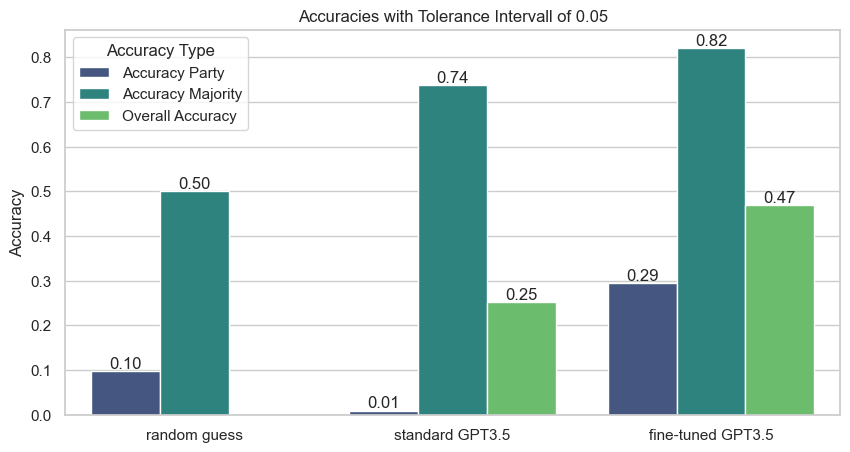

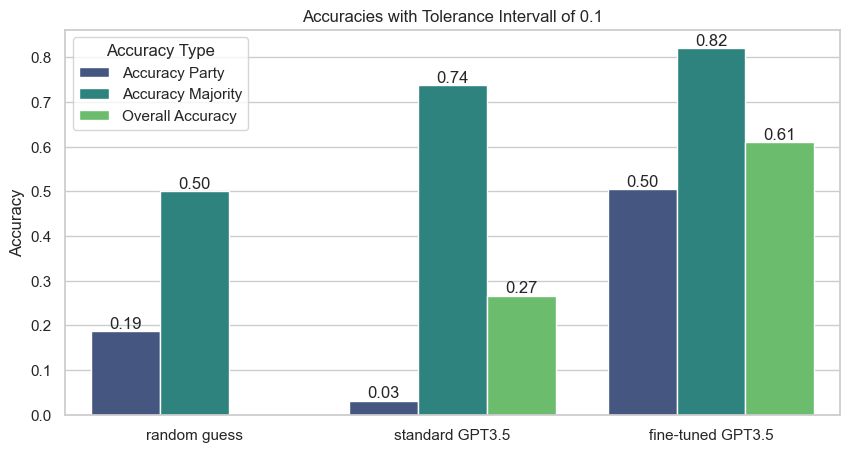

In [19]:
# Correct implementation to have grouped bars for each model and each accuracy type

# Preparing data by melting the dataframe for easy plotting with seaborn
acc_results_05_long = acc_results_05.reset_index().melt(id_vars="index", 
                                                        value_vars=["Accuracy Party", "Accuracy Majority", "Overall Accuracy"], 
                                                        var_name="Accuracy Type", 
                                                        value_name="Accuracy")

# Plotting the grouped barplot
plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=acc_results_05_long, x="index", y="Accuracy", hue="Accuracy Type", palette="viridis")

# Adding values to each bar using bar_label
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.title("Accuracies with Tolerance Intervall of 0.05")
plt.xlabel(None)
plt.ylabel("Accuracy")
plt.legend(title="Accuracy Type")
plt.show()

# Same for threshold 0.1
# Preparing data by melting the dataframe for easy plotting with seaborn
acc_results_01_long = acc_results_01.reset_index().melt(id_vars="index", 
                                                        value_vars=["Accuracy Party", "Accuracy Majority", "Overall Accuracy"], 
                                                        var_name="Accuracy Type", 
                                                        value_name="Accuracy")

# Plotting the grouped barplot
plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=acc_results_01_long, 
            x="index",
            y="Accuracy", 
            hue="Accuracy Type", 
            palette="viridis",
            )
# Adding values to each bar using bar_label
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.title("Accuracies with Tolerance Intervall of 0.1")
plt.xlabel(None)
plt.ylabel("Accuracy")
plt.legend(title="Accuracy Type")
